# Part I - Exploratory Data Analysis of Ford GoBike System Data:
## by Charaf El Berdai

## Introduction
The data is about individual rides made in the bike-sharing system [CitibikeNYC](https://ride.citibikenyc.com/system-data) covering New York City, NY. The data is providied in monthly batches. This analysis will combine the data from all 12 months of 2018. The data includes the followig fields:

* tripduration (seconds)
* starttime	(time and date)
* stoptime	(time and date)
* start station id	
* start station name	
* start station latitude	
* start station longitude	
* end station id	
* end station name	
* end station latitude	
* end station longitude	
* bikeid	
* usertype  (Customer = 24-hour pass or 3-day pass user; Subscriber = Annual Member)
* birth year	
* gender (Zero=unknown; 1=male; 2=female)

We will also be using data of [population distribution by age](https://www.health.ny.gov/statistics/vital_statistics/2018/table01.htm) from the new york department of health. It will be used when dealing with age related analysis for normalization by age group. This data includes the following fields:
* Age Group
* All (all genders)
* Male
* Female

## Preliminary Wrangling


In [1]:
#import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
#Load population distribution dataset
nyc_population = pd.read_csv('nyc_agegroup_population_2018.csv')

In [3]:
#Load and merge tripdata datasets
datasets = ['201801-citibike-tripdata.csv',
            '201802-citibike-tripdata.csv',
            '201803-citibike-tripdata.csv',
            '201804-citibike-tripdata.csv',
            '201805-citibike-tripdata.csv',
            '201806-citibike-tripdata.csv',
            '201807-citibike-tripdata.csv',
            '201808-citibike-tripdata.csv',
            '201809-citibike-tripdata.csv',
            '201810-citibike-tripdata.csv',
            '201811-citibike-tripdata.csv',
            '201812-citibike-tripdata.csv',
           ]
#use total rows to check that all dataframes were loaded and concatenated successfully
sampling = False
sample_frac = 0.2
total_rows = 0
for dataset in datasets:
    trip_data_n = pd.read_csv(dataset)
    #########################""
    if sampling == True:
        trip_data_n = trip_data_n.sample(frac=sample_frac)
    ##################################
    if total_rows == 0:
        trip_data = trip_data_n
    else:
        trip_data = pd.concat([trip_data,trip_data_n], axis=0)
    total_rows += trip_data_n.shape[0]
    del trip_data_n #free up memory

In [4]:
#Test that all the data was loaded and concatenated successfully
assert total_rows == trip_data.shape[0]

In [5]:
#It is expected that there would be duplicates as the data that was loaded would share indexes as they are not consecutive
trip_data.index.duplicated().sum()

15571162

In [6]:
#reset index
trip_data.reset_index(inplace=True, drop=True)

### Assessing the Data

#### Population Data Assessment

This data will be assessed visually due to the low number of observations and straightforward structure of the dataset. The datatypes will also be checked.

In [7]:
nyc_population.head(nyc_population.shape[0])

,Age Group,All,Male,Female
0,< 1,"112,206","57,362","54,844"
1,1,"108,724","55,730","52,994"
2,2,"107,238","54,961","52,277"
3,3,"105,093","53,623","51,470"
4,4,"101,979","51,880","50,099"
5,5-9,"485,720","248,478","237,242"
6,10-14,"450,993","229,697","221,296"
7,15-17,"267,569","135,483","132,086"
8,18-19,"176,598","87,736","88,862"
9,20-24,"534,372","257,674","276,698"


In [8]:
nyc_population.dtypes

Age Group    object
All          object
Male         object
Female       object
dtype: object

##### Assessment Findings
* 2 data quality issues were identified.
    1. Column name All is an issue since it is a keyword and column names need to be change to lowercase and spaces replaced with underscores for consistency.
    2. The 3 population columns are strings with commas and need to be converted into integers


* Only data for age groups of 18+ will be kept since age 15 and lower riders are not present in the rides dataset.


#### Trip Data Assessment

The assessment will be primarily programatic due to the large amount of observations.

In [9]:
#visual overhead of the data to understad the main structure
trip_data.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,970,2018-01-01 13:50:57.4340,2018-01-01 14:07:08.1860,72.0,W 52 St & 11 Ave,40.767272,-73.993929,505.0,6 Ave & W 33 St,40.749013,-73.988484,31956,Subscriber,1992,1
1,723,2018-01-01 15:33:30.1820,2018-01-01 15:45:33.3410,72.0,W 52 St & 11 Ave,40.767272,-73.993929,3255.0,8 Ave & W 31 St,40.750585,-73.994685,32536,Subscriber,1969,1
2,496,2018-01-01 15:39:18.3370,2018-01-01 15:47:35.1720,72.0,W 52 St & 11 Ave,40.767272,-73.993929,525.0,W 34 St & 11 Ave,40.755942,-74.002116,16069,Subscriber,1956,1
3,306,2018-01-01 15:40:13.3720,2018-01-01 15:45:20.1910,72.0,W 52 St & 11 Ave,40.767272,-73.993929,447.0,8 Ave & W 52 St,40.763707,-73.985162,31781,Subscriber,1974,1
4,306,2018-01-01 18:14:51.5680,2018-01-01 18:19:57.6420,72.0,W 52 St & 11 Ave,40.767272,-73.993929,3356.0,Amsterdam Ave & W 66 St,40.774667,-73.984706,30319,Subscriber,1992,1


In [10]:
print(f'shape: {trip_data.shape}\n')
#check for missing values and datatypes
trip_data.info(verbose=True, show_counts=True)

shape: (17548339, 15)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17548339 entries, 0 to 17548338
Data columns (total 15 columns):
 #   Column                   Non-Null Count     Dtype  
---  ------                   --------------     -----  
 0   tripduration             17548339 non-null  int64  
 1   starttime                17548339 non-null  object 
 2   stoptime                 17548339 non-null  object 
 3   start station id         17545842 non-null  float64
 4   start station name       17545842 non-null  object 
 5   start station latitude   17548339 non-null  float64
 6   start station longitude  17548339 non-null  float64
 7   end station id           17545842 non-null  float64
 8   end station name         17545842 non-null  object 
 9   end station latitude     17548339 non-null  float64
 10  end station longitude    17548339 non-null  float64
 11  bikeid                   17548339 non-null  int64  
 12  usertype                 17548339 non-null  object 
 13  bi

In [11]:
trip_data.duplicated().sum()

0

In [12]:
trip_data.describe()

,tripduration,start station id,start station latitude,start station longitude,end station id,end station latitude,end station longitude,bikeid,birth year,gender
count,1.754834e+07,1.754584e+07,1.754834e+07,1.754834e+07,1.754584e+07,1.754834e+07,1.754834e+07,1.754834e+07,1.754834e+07,1.754834e+07
mean,9.887432e+02,1.589282e+03,4.073737e+01,-7.398260e+01,1.580830e+03,4.073704e+01,-7.398281e+01,2.656141e+04,1.978993e+03,1.148613e+00
std,1.889584e+04,1.439432e+03,3.225813e-02,1.912753e-02,1.438502e+03,3.206583e-02,1.919611e-02,6.222916e+03,1.192922e+01,5.438043e-01
min,6.100000e+01,7.200000e+01,4.064654e+01,-7.402535e+01,7.200000e+01,4.064654e+01,-7.408364e+01,1.452900e+04,1.885000e+03,0.000000e+00
25%,3.580000e+02,3.800000e+02,4.071755e+01,-7.399521e+01,3.800000e+02,4.071755e+01,-7.399595e+01,2.029300e+04,1.969000e+03,1.000000e+00
50%,6.050000e+02,5.050000e+02,4.073818e+01,-7.398565e+01,5.050000e+02,4.073756e+01,-7.398602e+01,2.827000e+04,1.981000e+03,1.000000e+00
75%,1.060000e+03,3.249000e+03,4.075763e+01,-7.397283e+01,3.249000e+03,4.075725e+01,-7.397344e+01,3.185200e+04,1.989000e+03,1.000000e+00
max,1.951005e+07,3.721000e+03,4.550636e+01,-7.356891e+01,3.721000e+03,4.550636e+01,-7.356891e+01,3.583100e+04,2.002000e+03,2.000000e+00


From the overview description above, the minimum birth year was 1885 which is unreasonable and unexpected. We need to further assess the birthyear information.

In [13]:
trip_data[trip_data['birth year'] < 1918]

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
2787,944,2018-01-27 11:41:22.7260,2018-01-27 11:57:06.8930,82.0,St James Pl & Pearl St,40.711174,-74.000165,2008.0,Little West St & 1 Pl,40.705693,-74.016777,19760,Subscriber,1900,1
17277,663,2018-01-16 18:13:56.2490,2018-01-16 18:24:59.9440,161.0,LaGuardia Pl & W 3 St,40.729170,-73.998102,152.0,Warren St & Church St,40.714740,-74.009106,31117,Subscriber,1912,0
17404,844,2018-01-18 16:04:22.0420,2018-01-18 16:18:26.8830,161.0,LaGuardia Pl & W 3 St,40.729170,-73.998102,534.0,Water - Whitehall Plaza,40.702551,-74.012723,21654,Subscriber,1912,0
17765,972,2018-01-22 18:13:58.2430,2018-01-22 18:30:10.6470,161.0,LaGuardia Pl & W 3 St,40.729170,-73.998102,534.0,Water - Whitehall Plaza,40.702551,-74.012723,16278,Subscriber,1912,0
17849,1005,2018-01-23 17:22:48.3270,2018-01-23 17:39:33.9640,161.0,LaGuardia Pl & W 3 St,40.729170,-73.998102,534.0,Water - Whitehall Plaza,40.702551,-74.012723,31473,Subscriber,1912,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17543778,523,2018-12-31 14:03:27.3290,2018-12-31 14:12:10.7260,3414.0,Bergen St & Flatbush Ave,40.680945,-73.975673,3673.0,Dean St & Franklin Ave,40.677592,-73.955637,33166,Subscriber,1895,1
17544295,417,2018-12-31 14:25:45.6910,2018-12-31 14:32:43.4210,297.0,E 15 St & 3 Ave,40.734232,-73.986923,3711.0,E 13 St & Avenue A,40.729667,-73.980680,35117,Subscriber,1890,2
17546200,192,2018-12-31 16:11:30.2290,2018-12-31 16:14:43.2250,545.0,E 23 St & 1 Ave,40.736502,-73.978095,487.0,E 20 St & FDR Drive,40.733143,-73.975739,16285,Subscriber,1900,1
17546343,626,2018-12-31 16:22:31.2100,2018-12-31 16:32:57.4530,267.0,Broadway & W 36 St,40.750977,-73.987654,380.0,W 4 St & 7 Ave S,40.734011,-74.002939,35147,Subscriber,1917,1


##### Assessment Findings
* 4 data quality issues were identified.
    1. Some column names have spaces which is not ideal for coding and should be replaced with underscores.
    2. There are 2497 missing values in 'start_station_id', 'start_station_name', 'end_station_id', 'end_station_name'. This is unexpected since there are no missing values for 'start_station_latitude'/'start_station_longitude' and 'end_station_latitude'/'end_station_longitude'. This will be investigated below. An attemmpt to extract those values using the longitude and latitude coordinates.
    3. Birth years go as far back as 1886 and 11147 trips that have the user's age at about 100 or more. This certainly raises issues regarding the validity and accuracy of the birth years provided in the dataset.
    4. Datatype corrections: Convert to datetime the 'starttime' and 'stoptime' features and convert to int the 'tripduration', 'start station id', 'end station id', 'bikeid', 'birth year', 'gender' features since all are supposed to be whole numbers.
* Drop the following columns to free up memory since they will not be used in our analysis: 
    - start station id
    - start station name
    - start station latitude
    - start station longitude
    - end station id
    - end station name
    - end station latitude
    - end station longitude
    - bikeid

### Data Cleaning

#### Population Data Cleaning

1. Column name All is an issue since it is a keyword and column names need to be change to lowercase for consistency.
2. The 3 population columns are strings with commas and need to be converted into integers.
3. Remove age groups below 18

###### Code

##### Issue #1: Ammending column names

In [14]:
nyc_population.rename(columns={'Age Group': 'age_group','All':'combined', 'Male': 'male', 'Female':'female'}, inplace=True)

###### Test

In [15]:
nyc_population.columns

Index(['age_group', 'combined', 'male', 'female'], dtype='object')

##### Issue #2: Ammending datatypes

###### Code

In [16]:
columns = ('combined', 'male', 'female')
for column in columns:
    nyc_population[column] = nyc_population[column].str.replace(',', '')
    nyc_population[column] = nyc_population[column].astype('int')

###### Test

In [17]:
nyc_population.head()

,age_group,combined,male,female
0,< 1,112206,57362,54844
1,1,108724,55730,52994
2,2,107238,54961,52277
3,3,105093,53623,51470
4,4,101979,51880,50099


In [18]:
nyc_population.dtypes

age_group    object
combined      int64
male          int64
female        int64
dtype: object

##### Issue #3: Create a dataframe where age groups below 18 are removed for age group comparisons

###### Code

In [19]:
nyc_population_over18 = nyc_population.copy().iloc[8:]
nyc_population_over18.reset_index(inplace=True, drop=True)
del(nyc_population)

###### Test

In [20]:
nyc_population_over18.head(15)

,age_group,combined,male,female
0,18-19,176598,87736,88862
1,20-24,534372,257674,276698
2,25-29,776107,377117,398990
3,30-34,723193,356269,366924
4,35-39,613975,299914,314061
5,40-44,532840,256675,276165
6,45-49,529007,253777,275230
7,50-54,527046,251324,275722
8,55-59,522675,246047,276628
9,60-64,477320,219423,257897


#### Trip Data Cleaning

##### Issue #1: Remove Spacing from column names

###### Code

In [21]:
#Replace spaces in column names with underscores for easier manipulation
trip_data.columns = trip_data.columns.str.replace(' ', '_')

###### Test

In [22]:
assert ' ' not in trip_data.columns

##### Issue #2: Investigate missing values

###### Code

In [23]:
trip_data.isnull().sum()

tripduration                  0
starttime                     0
stoptime                      0
start_station_id           2497
start_station_name         2497
start_station_latitude        0
start_station_longitude       0
end_station_id             2497
end_station_name           2497
end_station_latitude          0
end_station_longitude         0
bikeid                        0
usertype                      0
birth_year                    0
gender                        0
dtype: int64

There are 2497 missing values in 'start_station_id', 'start_station_name', 'end_station_id', 'end_station_name'.

In [24]:
#Check if the nulls are all in the same observations or different ones. If they are the same, the filter below should return 2497 observations.
contain_nulls = trip_data[trip_data.start_station_id.isna() & trip_data.start_station_name.isna() & trip_data.end_station_id.isna() & trip_data.end_station_name.isna()]
2497 == contain_nulls.shape[0]

True

Now we have all the nulls that we will try to fill out by searching for stations with the same coordinates in the rest of the data.

In [25]:
#create a dataframe of unique coordinates to reduce the size and optimize the search
coordinates = pd.DataFrame()
coordinates['latitude'] = pd.concat([contain_nulls.start_station_latitude, contain_nulls.end_station_latitude], ignore_index=True)
coordinates['longitude'] = pd.concat([contain_nulls.start_station_longitude, contain_nulls.end_station_longitude], ignore_index=True)
coordinates.drop_duplicates(inplace=True)
coordinates.reset_index()

,index,latitude,longitude
0,0,40.857,-73.890
1,3,40.845,-73.902
2,6,40.854,-73.890
3,7,40.845,-73.893
4,9,40.842,-73.884
...,...,...,...
101,3652,40.866,-73.881
102,3997,40.866,-73.905
103,4046,40.869,-73.884
104,4579,40.854,-73.914


In [26]:
#for each unique coordinate set, check for matching coordinates in the rest of the data that has entries for station id.
matches = 0
for index, row in coordinates.iterrows():
    x = trip_data[(trip_data.start_station_latitude == row.latitude) &
      (trip_data.start_station_longitude == row.longitude)&
          (trip_data.start_station_id.notnull())]
    matches += x.shape[0]
print(f'{matches} matches found.')

0 matches found.


In [27]:
#Since no matches were found, the only option left is to drop those rows.
trip_data.drop(contain_nulls.index, inplace=True)

###### Test

In [28]:
assert trip_data.isnull().sum().sum() == 0

###### Issue #3: Birth Year discrepencies

There is no solution to solve this issue. We will try to understand it further when visually exploring the data and making conclusions. This is probably due to unverified entries by users.

###### Issue #4: Datatype corrections

###### Code

In [29]:
##### Test# Convert to datetime the 'starttime' and 'stoptime' features
to_datetime = ['starttime', 'stoptime']
for column in to_datetime:
    trip_data[column] = trip_data[column].astype('datetime64[s]') #we do not need nanosecond resolution. Seconds is enough.
# Convert to int since all are supposed to be whole numbers
to_int = ['tripduration', 'start_station_id', 'end_station_id', 'bikeid', 'birth_year', 'gender']
for column in to_int:
    trip_data[column] = trip_data[column].astype(int)

###### Test

In [30]:
trip_data.dtypes

tripduration                        int64
starttime                  datetime64[ns]
stoptime                   datetime64[ns]
start_station_id                    int64
start_station_name                 object
start_station_latitude            float64
start_station_longitude           float64
end_station_id                      int64
end_station_name                   object
end_station_latitude              float64
end_station_longitude             float64
bikeid                              int64
usertype                           object
birth_year                          int64
gender                              int64
dtype: object

###### Issue #5: Removed columns that will not be used in our analysis

In [31]:
trip_data.drop(axis=1, labels=['start_station_id',
                              'start_station_name',
                               'start_station_latitude',
                               'start_station_longitude',
                               'end_station_id',
                              'end_station_name',
                               'end_station_latitude',
                               'end_station_longitude',
                               'bikeid'
                              ],
               inplace=True,
              )

In [32]:
trip_data.columns

Index(['tripduration', 'starttime', 'stoptime', 'usertype', 'birth_year',
       'gender'],
      dtype='object')

### Dataset's Structure

> The data is a collection of 17,548,339 rides with 15 features 

### What is/are the main feature(s) of interest in your dataset?

> I am most interested in finding which factors affect usage rates. These factors are time factors (time of day, day of the week, and season) and rider factors (gender, usertype, and age group).

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

> It is expected that all the selected features will have an effect but to varying degrees. 

## Univariate Exploration

In [33]:
#base color for all visualizations
base_color = sns.color_palette()[7]

We will start by exploring time and rider variables individualy.

### What is the distribution of Rides by Time of Day?

We will first look into an hourly overview of ride start times.

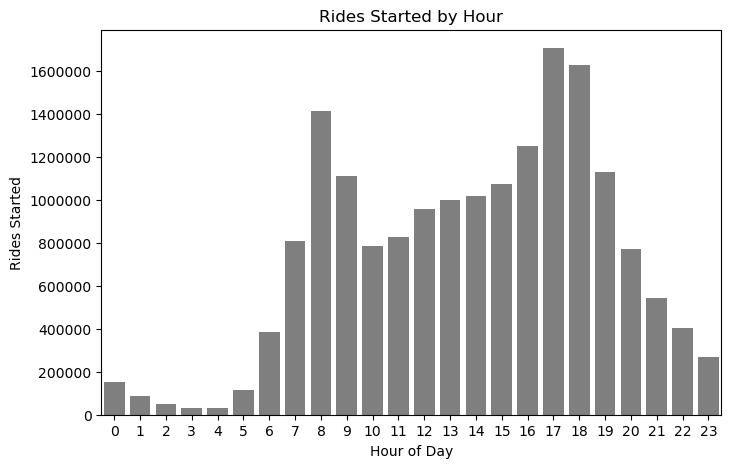

In [34]:
plt.figure(figsize=[8, 5]);
sns.countplot(x=trip_data.starttime.dt.hour, color=base_color);
plt.xlabel('Hour of Day');
plt.ylabel('Rides Started');
plt.ticklabel_format(style='plain', axis='y');
plt.title('Rides Started by Hour');

Next, we will look at 15 minute intervals for a greater resolution.

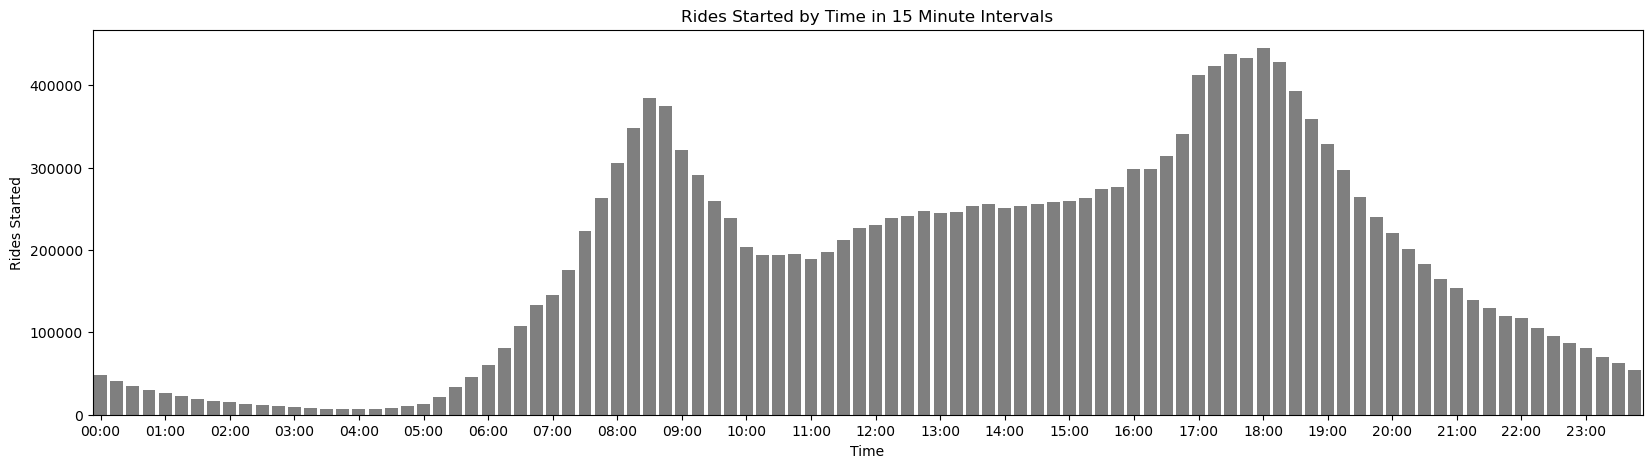

In [35]:
plt.figure(figsize=[20, 5]);
ax = sns.countplot(x=trip_data.starttime.dt.floor("15T").dt.time.sort_values(), color=base_color);

#Reduce the amount of ticks to display only full hours
xticks = np.arange(0,96,4);
x = ax.get_xticklabels()
xlabels = [x[i].get_text()[:5] for i in range(0,len(x), 4)]
plt.xticks(ticks=xticks, labels=xlabels);

#Labels
plt.xlabel('Time');
plt.ylabel('Rides Started');
plt.title('Rides Started by Time in 15 Minute Intervals');

Stop times will be plotted to see if there is a peak before 9 A.M which would suggest rides by commuters.

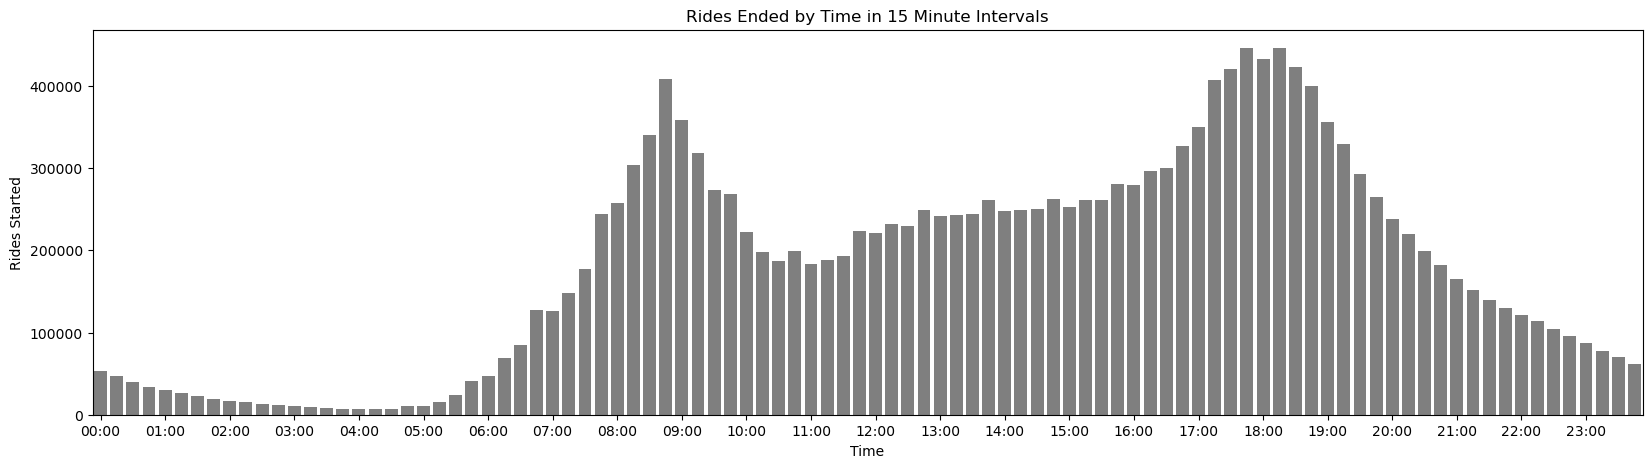

In [36]:
plt.figure(figsize=[20, 5]);
ax = sns.countplot(x=trip_data.stoptime.dt.floor("15T").dt.time.sort_values(), color=base_color);

#Reduce the amount of ticks to display only full hours
xticks = np.arange(0,96,4);
x = ax.get_xticklabels()
xlabels = [x[i].get_text()[:5] for i in range(0,len(x), 4)]
plt.xticks(ticks=xticks, labels=xlabels);

#Labels
plt.xlabel('Time');
plt.ylabel('Rides Started');
plt.title('Rides Ended by Time in 15 Minute Intervals');

The number of ride starts per hour has a bimodal distribution. If we consider the typical working day of a week, we would expect the number of commuters to start increasing gradually from 5 A.M and peak right before 9 A.M which is when most jobs starts. We would then expect a significant drop of commutes but other types of travel to continue. We would then expect commutes to pick up again after 5 P.M which is the end of the 9 to 5 job cycle and peak soon after.  Then we would get a tapring off of ride numbers as more and more people end their day outside and are done with travel. It is noteworthy that the afternoon peak is much more significant and there are a lot more rides than in the morning which suggests additional user groups. This is generally outlined and supported by the graphs including the peak of rides that end before 9A.M and the sudden increase of rides that start at 5P.M. 

The activity between the two peaks is significant which suggests continuous and varied usage of the bikes. Activity at night tapers out as expected and consistently with general human activity. To either provide further evidence or  dicredit the hypothesis that commuters are responsible for this pattern, we will need to compare this activity on working days which are generally weekdays to the weekend and holidays. This analysis will be carried out in the bivariate analysis section.

### Is there a difference in the Number of Rides between different Days of the Week?

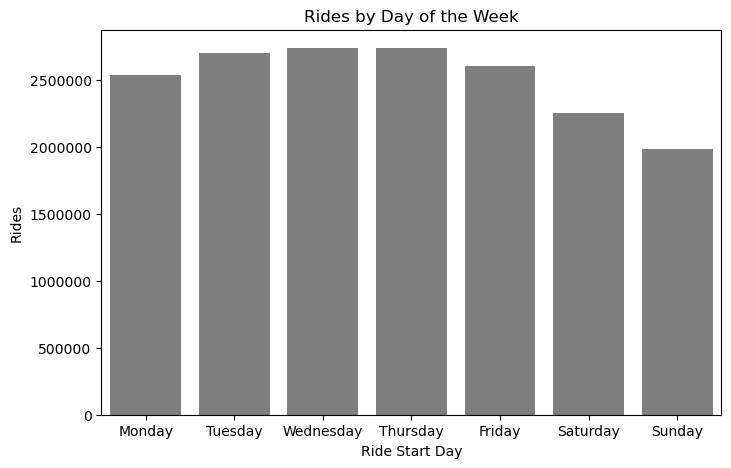

In [37]:
plt.figure(figsize=[8, 5]);
sns.countplot(x=trip_data.starttime.dt.day_name(), color=base_color);
plt.xlabel('Ride Start Day')
plt.ylabel('Rides')
plt.title('Rides by Day of the Week');
plt.ticklabel_format(style='plain', axis='y')

The plot shows less rides over the weekend though not as much of a difference to weekdays as one might expect. This shows that the bikes are used for travel consistently and for various purposes; not just for commuting.

### Does the the number of rides vary depending on general weather conditions year?

A more accurate analysis would need augmenting this dataset with temperature and other general weather conditions during particular hours and days. For this analysis, we will simply look at months and the different seasons.

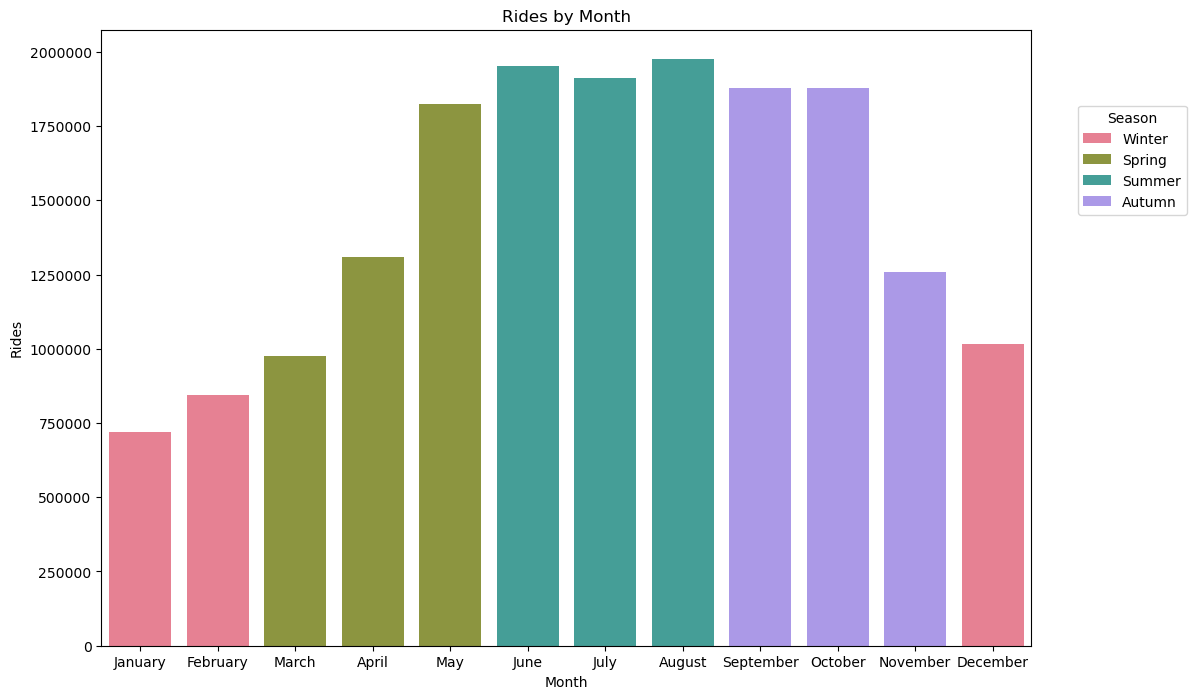

In [38]:
def season(month_name):
    if month_name in ('December', 'January', 'February'):
        return 'Winter'
    elif month_name in ('March', 'April', 'May'):
        return 'Spring'
    elif month_name in ('June', 'July', 'August'):
        return 'Summer'
    elif month_name in ('September', 'October', 'November'):
        return 'Autumn'

fig, ax = plt.subplots(figsize=(12,8))
sns.countplot(x=trip_data.starttime.dt.month_name(), palette="husl", hue=trip_data.starttime.dt.month_name().apply(season),dodge=False);
plt.legend(title='Season',loc=(1.05,0.7));
plt.xlabel('Month');
plt.ylabel('Rides');
plt.ticklabel_format(style='plain', axis='y');
plt.title('Rides by Month');

Bike usage does fluctuate along the year peaking during the summer months. This suggests a temperature and weather sensitivity of riders as usage is a lot less during colder and rainy months. Data of multiple years would be needed to confirm this trend. We could further investigate this trend if we had high resolution and area specific weather data by looking at higher resolution timeframes. 

### What is the distribution of Ride Durations?

In [39]:
#Display the statistics in minutes
trip_data.tripduration.describe().apply(lambda x: format(x/60, 'f'))

count    292430.700000
mean         16.474576
std         314.931868
min           1.016667
25%           5.966667
50%          10.083333
75%          17.666667
max      325167.483333
Name: tripduration, dtype: object

The max value is 325167 minutes which is equivalent to about 226 days; an unreasonably long ride duration. We will explore using visualizations and suppress unreaonable outliers.

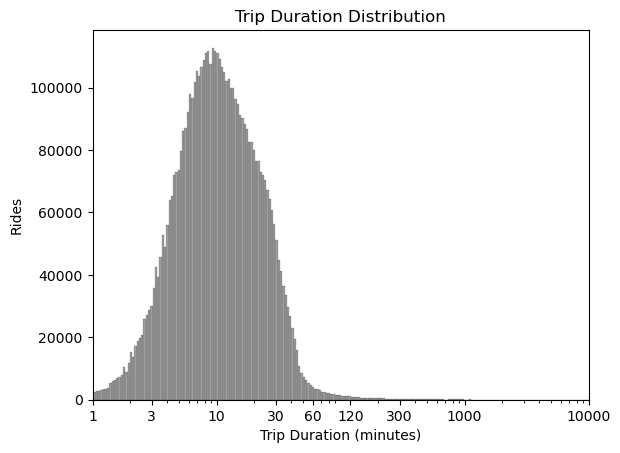

In [40]:
trip_data_sample = trip_data.sample(frac=0.3)
sns.histplot(trip_data_sample.tripduration/60, log_scale=True, bins=300, color=base_color);
x_ticks= [1, 3, 10, 30, 60, 120, 300, 1000, 10000];
x_labels = [1, 3, 10, 30, 60, 120, 300, 1000, 10000];
plt.xticks(ticks= x_ticks, labels= x_labels);
plt.xlim(1, 10000)
plt.xlabel('Trip Duration (minutes)')
plt.ylabel('Rides')
plt.title('Trip Duration Distribution');

From the chart above, we can see that most of the data is between 0 and 60 minutes. We will focus on that range for this analysis.

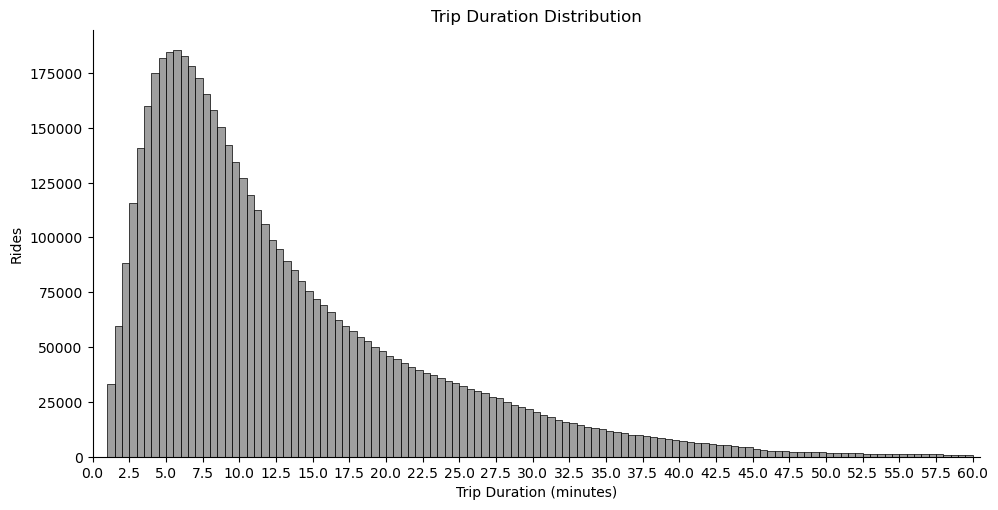

In [41]:
#filter data for rides less than or equal to 60 minutes.
bins = np.arange(0, 61, 0.5)
sns.displot(trip_data_sample[trip_data_sample.tripduration <= 60*60].tripduration/60, bins=bins, aspect=2 ,height=5, color=base_color);
plt.xticks(ticks=bins[0::5], labels=bins[0::5]);
plt.xlabel('Trip Duration (minutes)');
plt.ylabel('Rides');
plt.title('Trip Duration Distribution');
plt.margins(x=0)

The ride duration has a right-skewed distribution with many outliers. These outliers are expected due to some bikes that are lost or stolen before they are found, riders that keep them overnight, or one of many other reasons. When we zoom in and look at only the ride durations between 0 and 60 minutes, we get a clearer view. The peak is at 5 minutes which suggests that these bikes are mostly used for short trips although people still use them for longer rides.

### Is there a difference in usage rates among Genders?

According to [New York State's Department of Health's 2018 population data](https://www.health.ny.gov/statistics/vital_statistics/2018/table01.htm), out of 8,398,748 people, 47.70% (4,005,969) were male and 52.30% (4,392,779) were female. 

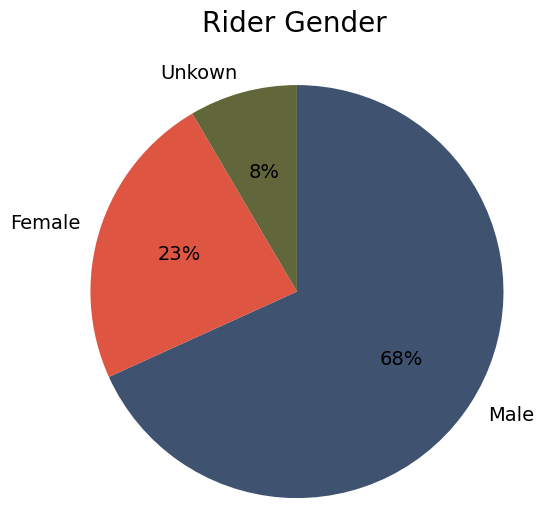

In [42]:
sorted_gender_counts = trip_data.gender.value_counts()
plt.figure(figsize = [6, 6]) 
plt.pie(sorted_gender_counts, labels= ['Male', 'Female', 'Unkown'], startangle = 90, counterclock = False, 
        colors= ['#3F5371','#DE5542','#62673B'], autopct='%.0f%%', textprops={'fontsize': 14});
plt.axis('square');
plt.title('Rider Gender', fontsize=20, pad=20);

For a more significant analysis, we will look at the rides per male and rides per female over a year. We will ommit the unknown gender rides since we do not have information on what it comprises.

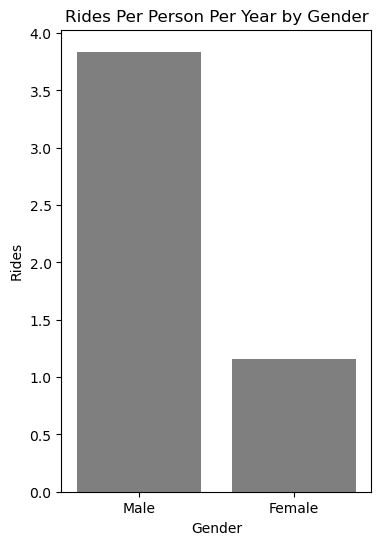

In [43]:
trip_data_male_female = trip_data[trip_data.gender != 0]
rides_per_person_per_gender = trip_data_male_female.gender.value_counts()/[nyc_population_over18.male.sum(),nyc_population_over18.female.sum()]

fig, ax = plt.subplots(figsize=(4,6))
sns.barplot(x=trip_data_male_female.gender.value_counts().index, y=rides_per_person_per_gender, color=base_color)
plt.xticks(ticks=[0,1], labels=['Male', 'Female']);
plt.xlabel('Gender');
plt.ylabel('Rides');
plt.title('Rides Per Person Per Year by Gender');
del trip_data_male_female

The data shows that females use these bikes a lot less than their male counterparts. There are more females than males in NY by about 3% but to fully acount of the gender population differences we would need further data about tourists as there were more than [60 million visitors in 2018](https://www.osc.state.ny.us/reports/osdc/tourism-industry-new-york-city). Using just the data about the resident population over 18, there are 3.75 rides per male per year while only 1.2 ride per female per year. This is a significant disparity that could be due to a multitude of reasons.

### What portion of total rides is by casual riders (Customers)?

Customer users are riders with 24-hour passes or 3-day passes. These are the casual riders that could be residents that very rarely use the bikes or tourists. Subscriber users are riders with annual memberships. These are very likely NYC residents that frequently use the bikes.

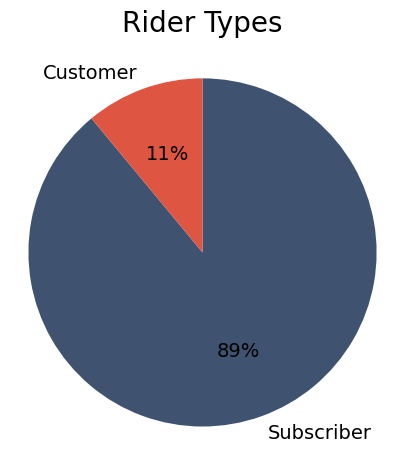

In [44]:
sorted_usertype_counts = trip_data.usertype.value_counts()
plt.figure(figsize = [5, 5])
plt.pie(sorted_usertype_counts, labels= ['Subscriber', 'Customer'], startangle = 90, counterclock = False, 
        colors= ['#3F5371','#DE5542','#62673B'], autopct='%.0f%%', textprops={'fontsize': 14});
plt.axis('square');
plt.title('Rider Types', fontsize=20, pad=20);
del(sorted_usertype_counts)

#### Observation
It is expected for the majority of riders to be subscribers.

### Which age group uses the bikes most?

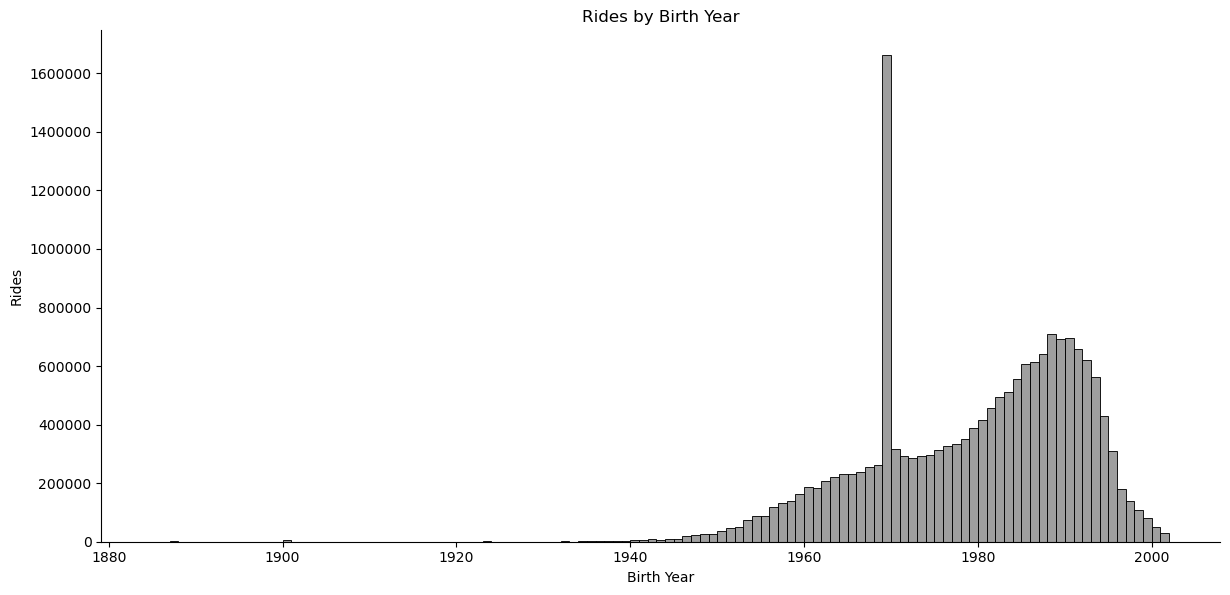

In [45]:
bins = np.arange(trip_data.birth_year.min(), trip_data.birth_year.max()+1, 1)
sns.displot(x = trip_data.birth_year, bins=bins, color=base_color, height=6, aspect=2);
plt.title('Rides by Birth Year');
plt.xlabel('Birth Year');
plt.ylabel('Rides');
plt.ticklabel_format(style='plain', axis='y');

1969 has a disporportionate share that is unreasonable. The birth years also extend back to 1885 which brings to question the validity of these entries as previously mentioned in the assessment phase. The possible explanation is that birth year is not verified for this service and that 1969 is the default birth year entry on their system. We will replace 1969's value counts by setting it to an average between 1968 and 1970 and further zoom in on birth years to the years between 1930 and the maximum year in this dataset. 

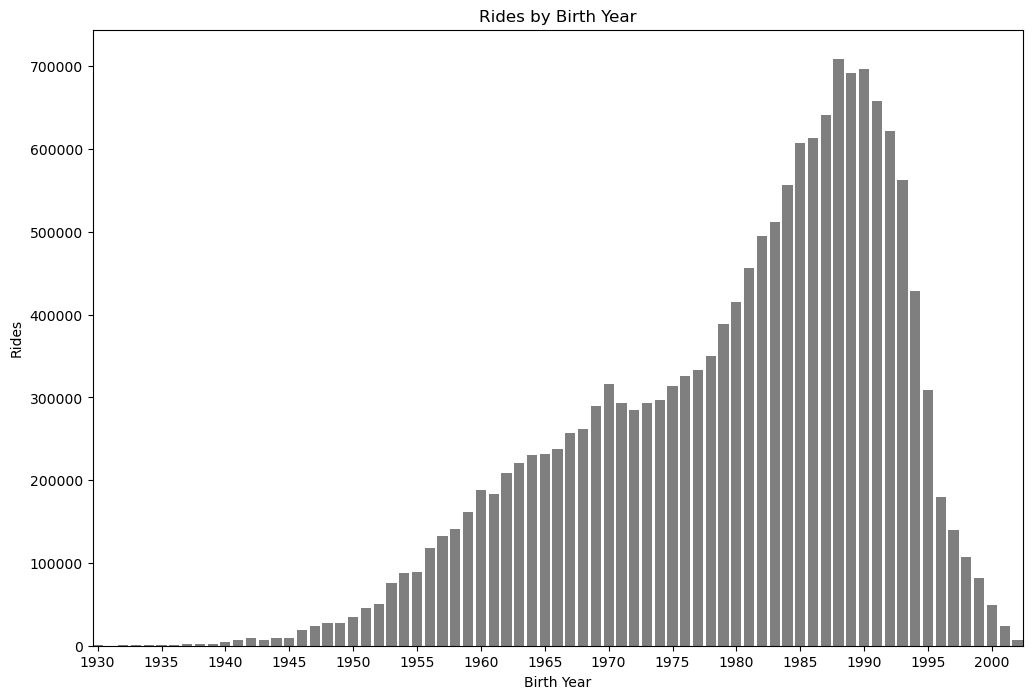

In [46]:
##Process to set the 1969 counts to an average of the preceding and following year and calculate age
def process_ride_counts(ride_counts):
    #set 1969 count as aver
    ride_counts[1969] = (ride_counts[1968] + ride_counts[1970])/2
    ride_counts = ride_counts.to_frame()
    ride_counts.rename(columns={'birth_year': 'rides'}, inplace=True)
    ride_counts.index.names = ['birth_year']
    ride_counts.reset_index(inplace=True)
    ride_counts['age'] = 2018-ride_counts.birth_year
    return ride_counts

#Only include data of riders who have a birth year greater than 1930
ride_counts = trip_data[trip_data.birth_year >=1930].birth_year.value_counts(sort=False)
ride_counts = process_ride_counts(ride_counts)
#plot
plt.figure(figsize=(12,8))
plt.bar(x=ride_counts.birth_year, height=ride_counts.rides, color=base_color);
plt.xticks(ticks=np.arange(1925,2002,5));
plt.margins(x=0)
plt.title('Rides by Birth Year');
plt.xlabel('Birth Year');
plt.ylabel('Rides');

A chart with Age on the x axis would be more intuitive but we are unable to accurately calculate age from birth year alone. Nonetheless we will produce a chart for a better intuitive understanding and keep in mind that some of the ages are overestimated by 1 year. We will look at the number of rides normalized by the population of each age group. We will look at groups starting with 18 year olds since the population data groups 15, 16, and 17 year olds together while ride data only includes +16 year olds and. Two plots will be plotted. One with total rides per age group and another one that is normalized by population.

In [47]:
def get_age_group_ride_count(nyc_population_over18, ride_counts, gender: str):
    #Get ride counts per age group
    age_groups = nyc_population_over18.age_group.str.replace('+', '', regex=True).str.split('-')
    age_groups_ride_count = []
    for age_group in age_groups:
        lower_end = int(age_group[0])
        if len(age_group)<2:
            upper_end = 88
        else: 
            upper_end= int(age_group[1])
        ages = np.arange(lower_end, upper_end+1,1)
        rides = 0
        for age in ages:
            rides += ride_counts[ride_counts.age == age].rides.sum()
        age_groups_ride_count.append(rides)
    nyc_population_over18[f'{gender}_rides_count'] = age_groups_ride_count
    return nyc_population_over18
nyc_population_over18 = get_age_group_ride_count(nyc_population_over18, ride_counts, gender='combined')

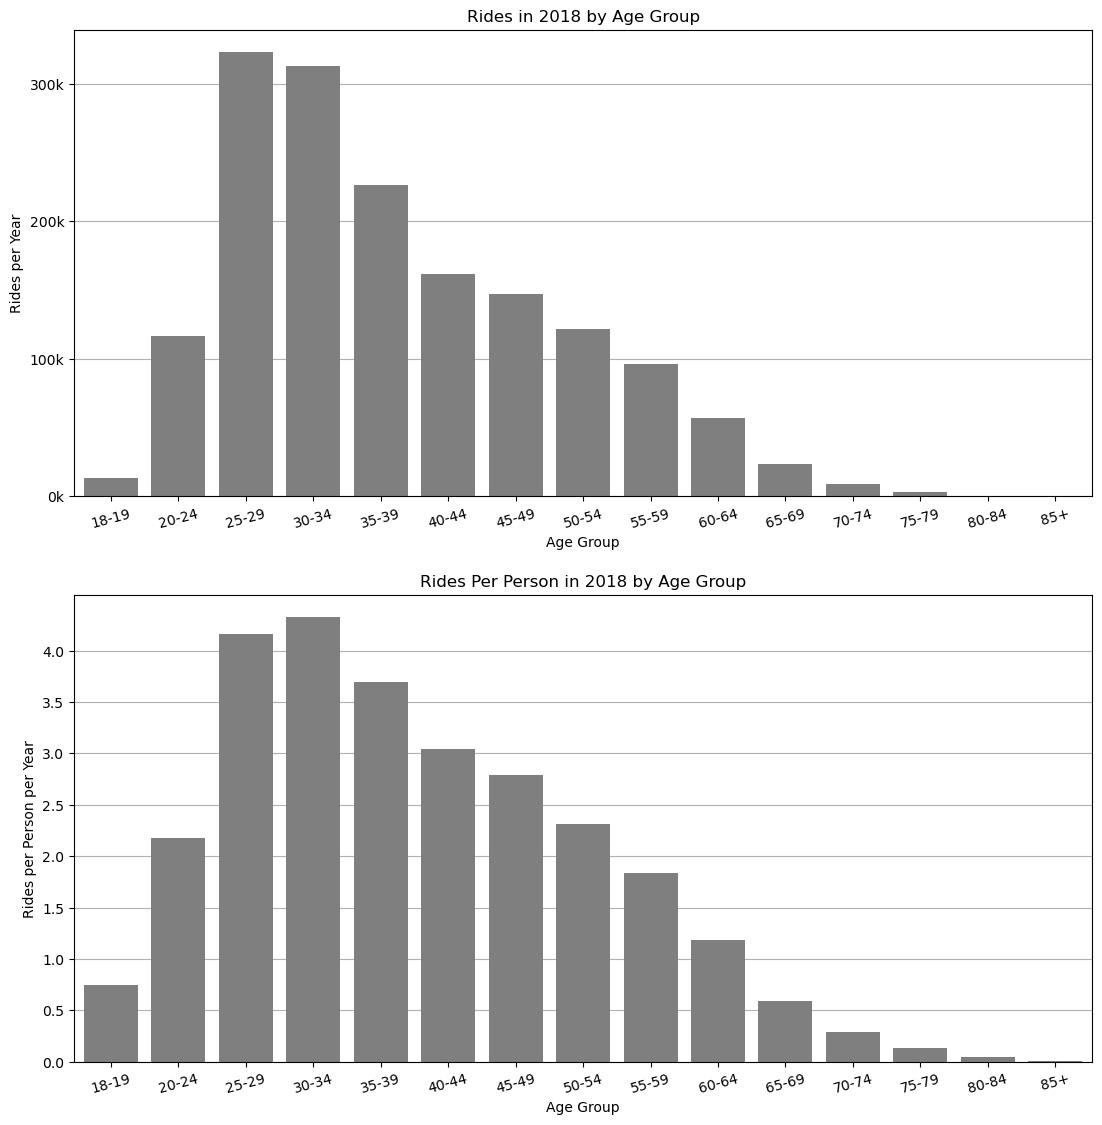

In [48]:
fig, ax = plt.subplots(nrows=2, figsize=(12,12))
fig.tight_layout(pad=5)
ax[0].bar(x=nyc_population_over18.age_group, height=nyc_population_over18.combined_rides_count, zorder=2, color=base_color)
yticks = np.arange(0, nyc_population_over18.combined_rides_count.max()+100000, 1000000)
ax[0].set_yticks(ticks=yticks, labels= [f'{str(x)[:3]}k' for x in yticks])
#yticks(ticks=yticks)
ax[0].grid(visible=True, axis='y', zorder=0,)
ax[0].tick_params(axis='x', labelrotation=15);
ax[0].set_title('Rides in 2018 by Age Group');
ax[0].set_xlabel('Age Group');
ax[0].set_ylabel('Rides per Year');
ax[0].margins(x=0.01)

ax[1].bar(x=nyc_population_over18.age_group, height=nyc_population_over18.combined_rides_count/nyc_population_over18.combined, zorder=2, color=base_color)
yticks = np.arange(0, nyc_population_over18.combined_rides_count.max()/nyc_population_over18.combined.max()+0.2, 0.5)
ax[1].set_yticks(ticks=yticks)
#yticks(ticks=yticks)
ax[1].grid(visible=True, axis='y', zorder=0,)
ax[1].tick_params(axis='x', labelrotation=15);
ax[1].set_title('Rides Per Person in 2018 by Age Group');
ax[1].set_xlabel('Age Group');
ax[1].set_ylabel('Rides per Person per Year');
ax[1].margins(x=0.01)


The distribution of riders on the birth year chart is left-skewed which is expected as biking requires physical exertion and we would expect younger people to be more likely to bike in comfort. The data when not normalized by the population of each age group is misleading. Normalizing the data by age group population provides several insights. The primary point of interest from this chart is why do the 18-19 and 20-24 age groups use these bikes much less than many of the older groups? The second point of interest is the gradual decline in usage rates with each increasing age group as opposed to a sharp decline at a certain age.

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

The hours at which people ride bikes is bimodal which is consistent with the work schedule and suggests a heavy use by commuters. The drop in rides during the weekend supports this suggestion. An analysis of the number of rides by month suggests a weather sensitivity of riders as would be expected. The number of rides peaks in the summer and drops at the end of autumn, rising again at the start of the summer. The distribution of ride durations showed that the bikes were mostly used for short trips (<10 minues) but that some riders used them for much longer trips. The distribution of rider genders showed a big disparity between male and female riders as males rode the bikes 3 times as often as females when adjusted for each gender's population. 


### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

The age distribution showed an unusual point where a high number of riders had a birth year of 1969. This was deemed a data quality issue due to the birth year not being verified and 1969 set as a default birth year in the system. There were also unlikely birth years due to the age the rider would be in 2018. The number of riders for 1969 was set to an average between 1968 and 1970 while the birth years for analysis were limited to greater than 1930. The data, charted by birth year, was left skewed as expected.

## Bivariate Exploration

### Does the distribution of Ride Starts by Time of Day vary between Weekdays and Weekends?

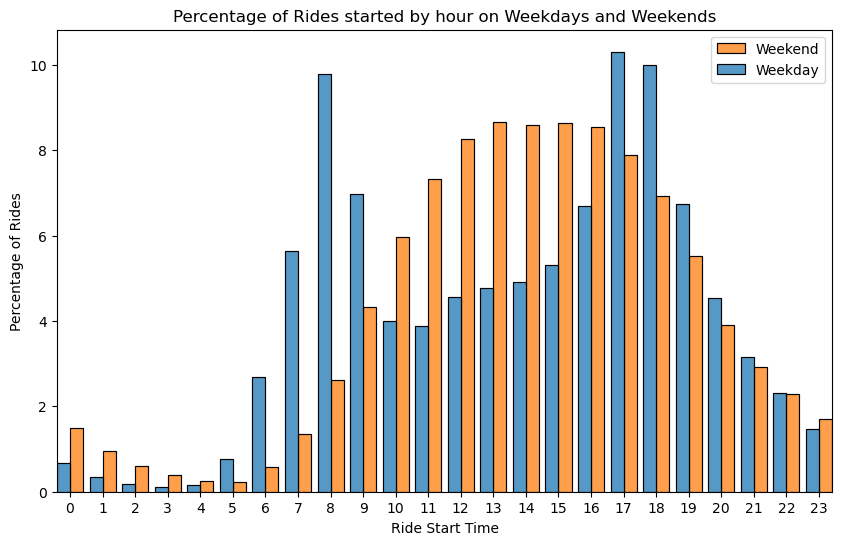

In [49]:
def day_type(day):
    if day > 4:
        return 'Weekend'
    else:
        return 'Weekday'
#plt.figure(figsize=(10,6))
fig, ax = plt.subplots(figsize=(10,6))
bins= np.arange(0,25,1)
sns.histplot(x=trip_data.starttime.dt.hour, hue=trip_data.starttime.dt.weekday.apply(day_type), 
             discrete=True, ax=ax, bins=bins, stat = 'percent', common_norm=False, multiple="dodge", shrink =0.8)
plt.xlabel('Ride Start Time');
plt.ylabel('Percentage of Rides');
plt.title('Percentage of Rides started by hour on Weekdays and Weekends');
plt.legend(['Weekend', 'Weekday'])
ax.margins(x=0);
ax.set_xticks(ticks=np.arange(0,24,1));


We will look at 15 minute intervals for a greater resolution.

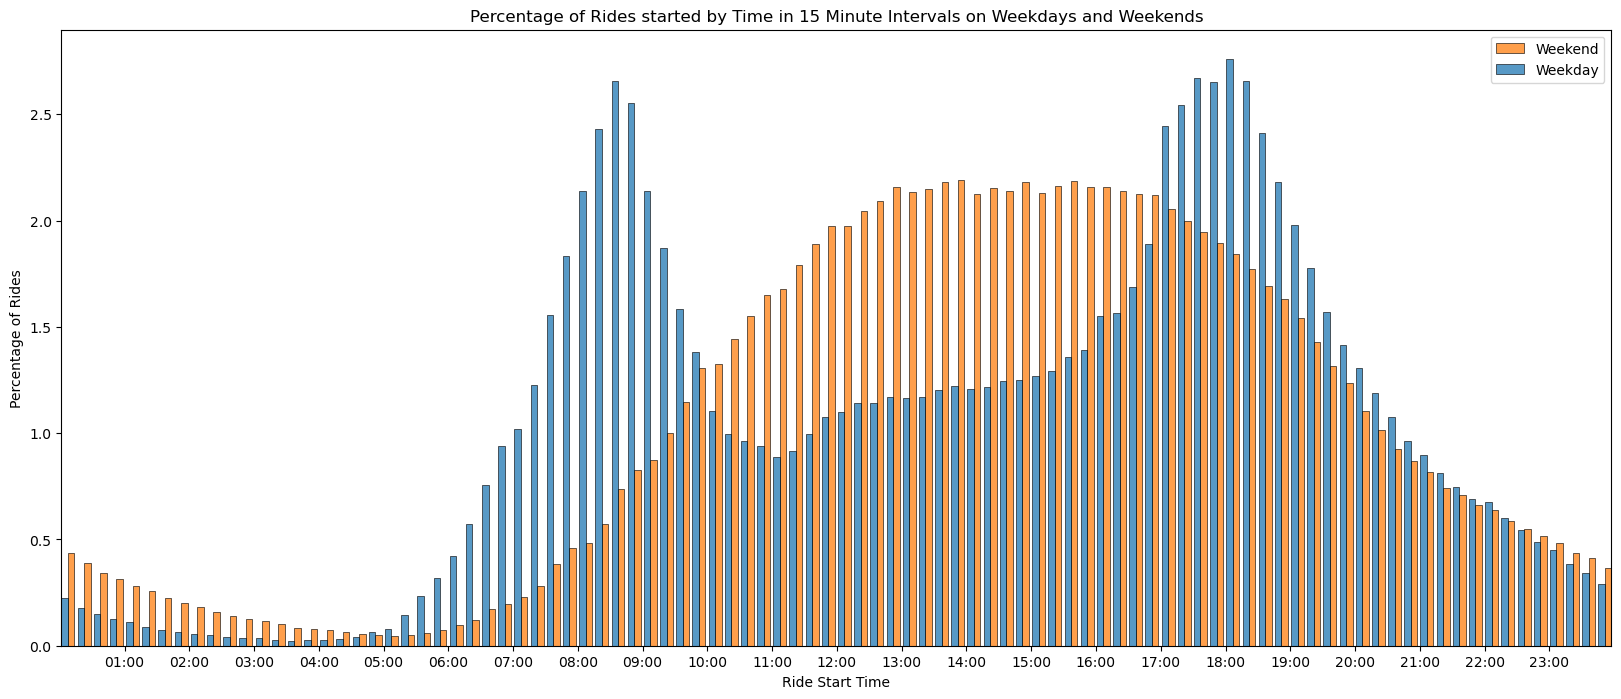

In [50]:
plt.figure(figsize=[20, 8]);
#plot the minute of day (total minutes) by adding the hours*60 and minutes of the datetime objects.
#96 bins will be used to plot 15 minute intervals
ax = sns.histplot(x= trip_data.starttime.dt.hour *60 + trip_data.starttime.dt.minute, 
                  bins = 24*4, hue=trip_data.starttime.dt.weekday.apply(day_type), 
             stat = 'percent', common_norm=False, multiple="dodge", shrink =0.8)
ticks = np.arange(0, 24*60,60);

#Format Tick Labels
labels = [f'{x}:00' for x in range(0,24,1) ];
labels = [f'0{x}' if len(x)<5 else x for x in labels ]

plt.xticks(ticks=ticks, labels=labels);
ax.margins(x=0);
ax.legend(['Weekend', 'Weekday'])
plt.xlabel('Ride Start Time');
plt.ylabel('Percentage of Rides');
plt.title('Percentage of Rides started by Time in 15 Minute Intervals on Weekdays and Weekends');

#### Observation
The distribution of rides by time is different during weekends. The weekend distribution is normal as opposed to the bimodal weeday distribution. In the weekend there are less commuters and people tend to wake up later and leave the house later for different purposes compared to the weekdays. The chart shows that there is a gradual increase that starts at 6A.M and a sustained peak beak between 12 and 5 P.M. The number of rides gradually declines after that. This clearly demonstrates that people use these bikes for different purposes during the weekend and that the wekday pattern is driven by commuters.

### Do different user types use the bikes more during different days of the week?

First the ride total ride counts by day will be explored.

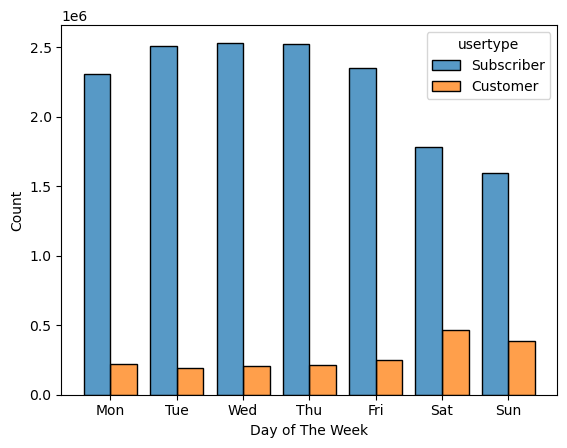

In [51]:
#Can't use day_name with histplot as it requires a numerical input so we will use day_of_week and label manually
sns.histplot(x=trip_data.starttime.dt.day_of_week, hue=trip_data.usertype, multiple='dodge', discrete=1, shrink=0.8 )
plt.xticks(ticks=range(0,7,1), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']);
plt.xlabel('Day of The Week');

Subscribers use the bikes less during the weekend while cusomters use them more. For a more accurate and interpretable picture, we will look at the percentage of rides for each user group during the days of the week. 

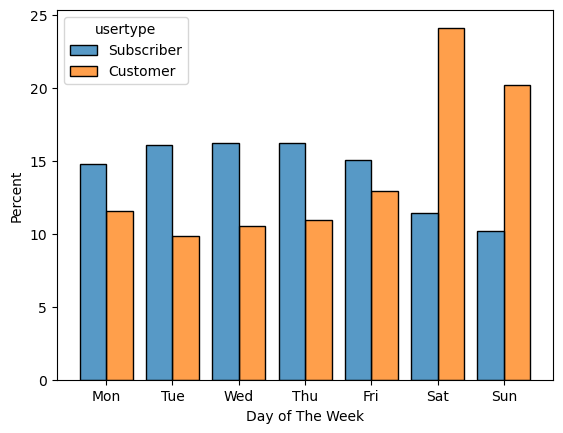

In [52]:
sns.histplot(x=trip_data.starttime.dt.day_of_week, hue=trip_data.usertype, multiple='dodge', discrete=1, 
             stat='percent', common_norm=False, shrink=0.8 )
plt.xticks(ticks=range(0,7,1), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']);
plt.xlabel('Day of The Week');

There is a clear difference in usage pattern over the week. About 45% of total customer rides were started over the weekend. There is a slight increase in percentage of rides on Friday too. Subscribers use the bikes more during the week with about only 22% of total rides on Saturday and Sunday combined.

### Do different user types use the bikes at different hours of the day?

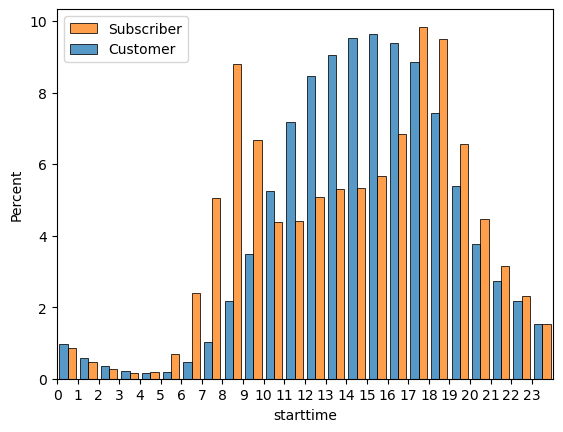

In [53]:
bins= np.arange(0,25,1)
ax = sns.histplot(x=trip_data_sample.starttime.dt.hour, hue=trip_data_sample.usertype, bins=bins, stat = 'percent', multiple="dodge", shrink = 0.8, common_norm=False)
plt.xticks(bins);
ax.set_xticks(ticks=np.arange(0,24,1));
ax.legend(['Subscriber', 'Customer'])
ax.margins(x=0.005);

#### Observation
Subscribers usage has a bimodal distribution with peaks at 8A.M and 5P.M which coincide with workhours. This suggests that a lot of people use them to commute to work. Customers on the other hand use them heavily during the middle of the day and very little at the early hours of the morning (6 to 9 A.M). This data indicates that the two groups use the service for different purposes and with different patterns. After 5P.M, the usage by the two types of users is similar.

### Do different user types use the bikes for different durations?

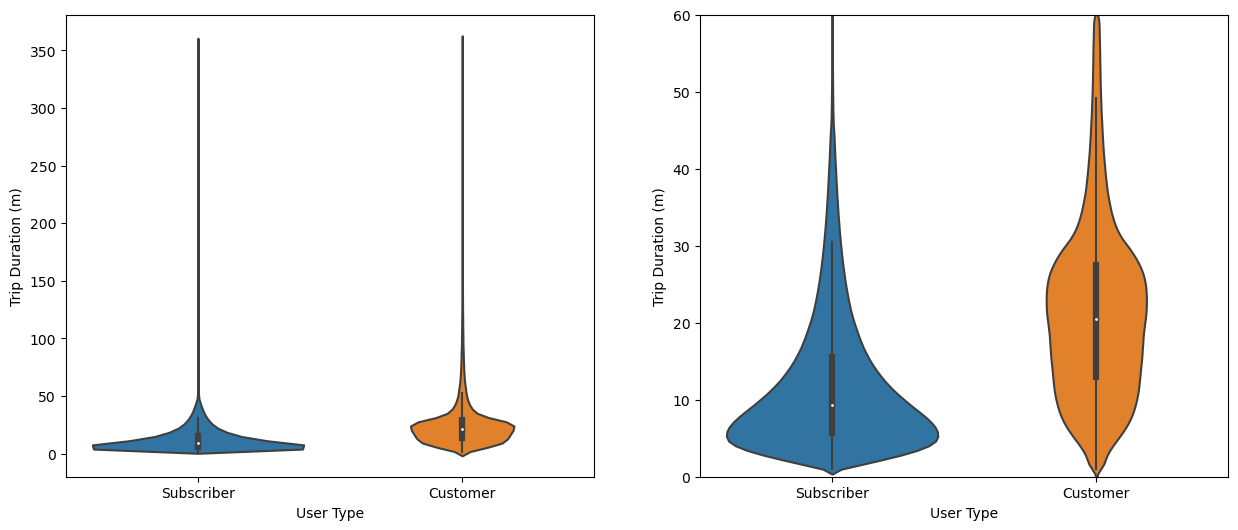

In [54]:
trip_data_sample = trip_data[trip_data.tripduration < 60*60*6]
fig, ax = plt.subplots(ncols=2, figsize=(15,6))
sns.violinplot(x=trip_data_sample.usertype, y=trip_data_sample.tripduration/60, ax=ax[0])
trip_data_sample = trip_data[trip_data.tripduration < 60*60*1]
sns.violinplot(x=trip_data_sample.usertype, y=trip_data_sample.tripduration/60, ax=ax[1])
ax[1].set_ylim(0,60)

for axis in ax:
    axis.set_xlabel('User Type')
    axis.set_ylabel('Trip Duration (m)')

In [55]:
trip_data_sample.groupby('usertype').tripduration.describe()/60

In [ ]:
del(trip_data_sample)

The distribution of ride durations among the two user types suggests very different usage purpose. Subscribers take shorter trips with a median of 10 and a concentrtion of rides below that mark. Customers have an almost evenly distributed ride duration between 10 and 30 minutes and a much higher median at 22 minutes. The interquartile range for subscribers is from 6 to 16 while that of the customers is from 13 to 27. Customer trip durations are longer and more varied.

### Do different genders have a different usage pattern along the week?

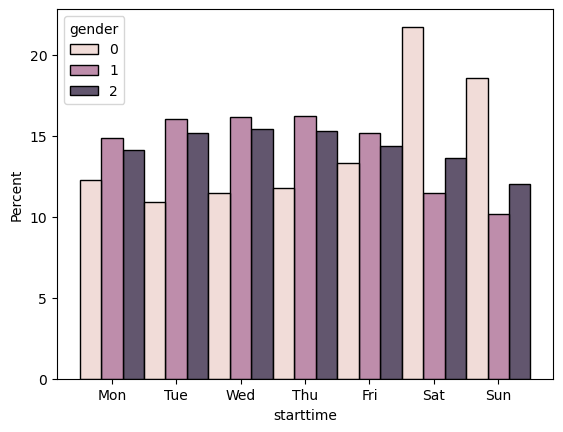

In [56]:
sns.histplot(x=trip_data.starttime.dt.day_of_week, hue=trip_data.gender, multiple='dodge', discrete=1, 
             stat='percent', common_norm=False)
plt.xticks(ticks=range(0,7,1), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']);

Other gender type tend to take more rides during the weekend. Customers rode more during the weekend and the latter could be an artifact of these casual riders not registering or leaving their gender input blank. We will compare the above chart to another one where we do not include customers to identify the plausibility of this artifact.

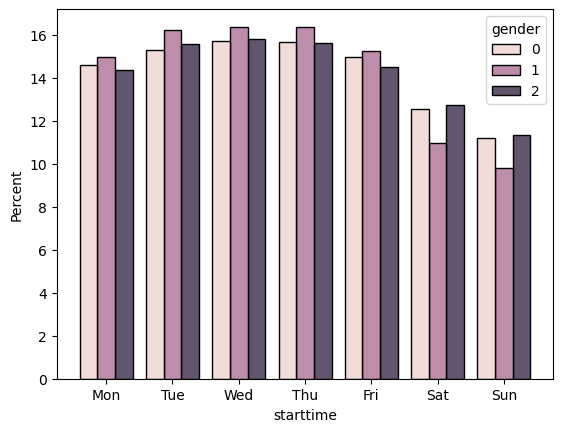

In [57]:
trip_data_sample = trip_data[trip_data.usertype != 'Customer']
sns.histplot(x=trip_data_sample.starttime.dt.day_of_week, hue=trip_data_sample.gender, multiple='dodge', discrete=1, 
             stat='percent', common_norm=False, shrink=0.8 )
plt.xticks(ticks=range(0,7,1), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']);
del(trip_data_sample)

The difference dissapears when we don't include customers. This confirms that it is very likely that this is due to the input and verification of gender rather than a distinct gender association for the 'other' gender attribution. Hence, we will only be looking at male and female genders in the rest of our gender analyses.
Females registered a higher percentage of rides over the weekend compared to males. The general distribution ver the week is the same.

### Do males and females have a different usage pattern along the day?

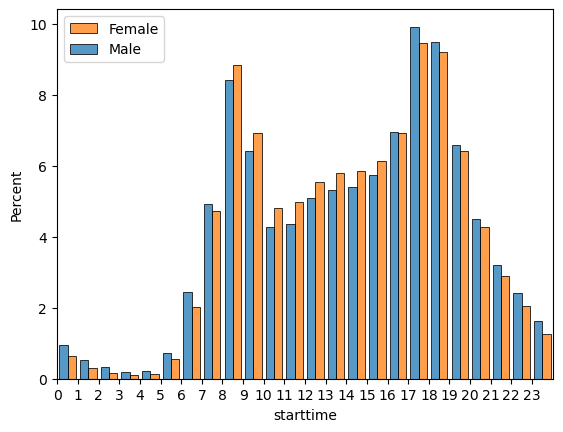

In [58]:
bins= np.arange(0,25,1)
colors = [sns.color_palette()[0], sns.color_palette()[1]]
ax = sns.histplot(x=trip_data[trip_data.gender != 0].starttime.dt.hour, hue=trip_data[trip_data.gender != 0].gender, 
             bins=bins, stat= 'percent', multiple="dodge", shrink = 0.8, common_norm=False, palette="tab10")

plt.xticks(bins);
ax.set_xticks(ticks=np.arange(0,24,1));
ax.margins(x=0.005);
ax.legend(['Female','Male']);

The percentage of rides of females and males is similar all through out the day.

### Does trip duration differ between Males and Females?

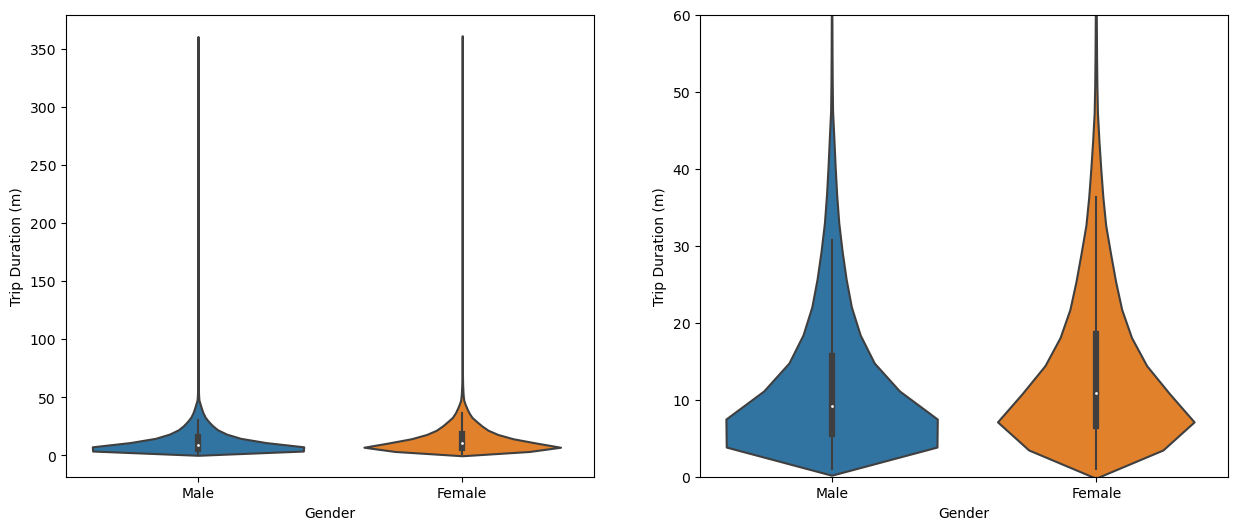

In [59]:
#We will only look at trips that are shorter than 6 hours.
trip_data_sample = trip_data[(trip_data.gender != 0) & (trip_data.tripduration < 60*60*6)]

fig, ax = plt.subplots(ncols=2, figsize=(15, 6))
sns.violinplot(x=trip_data_sample.gender, y=trip_data_sample.tripduration/60, ax=ax[0])
ax[0].set_xticks(ticks=range(2), labels=['Male', 'Female'])
#Facet for a max 60 min ride duration
sns.violinplot(x=trip_data_sample.gender, y=trip_data_sample.tripduration/60, ax=ax[1])
ax[1].set_ylim(0,60)
ax[1].set_xticks(ticks=range(2), labels=['Male', 'Female'])

for axis in ax:
    axis.set_xlabel('Gender')
    axis.set_ylabel('Trip Duration (m)')
del(trip_data_sample)

Ride durations by males and females have very similar general profiles. Females have a slightly higher median and interquartile range.

### Is there a difference in age group distribution among male and female riders?

We will look at the percentage of rides by age group for each gender.

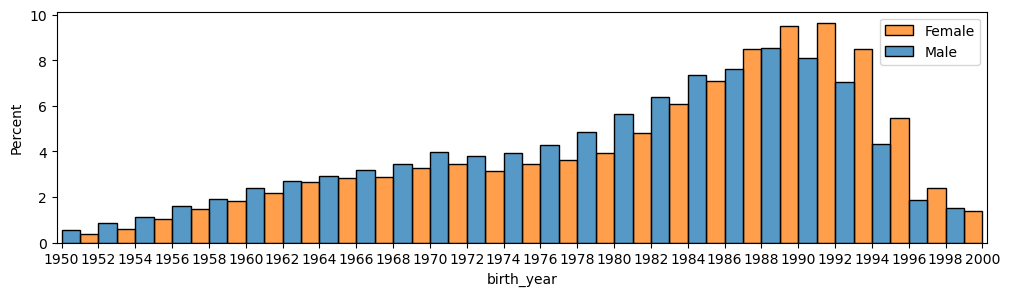

In [60]:
trip_data_sample = trip_data[(trip_data.birth_year >=1950) & (trip_data.gender !=0)]
fig, ax = plt.subplots(figsize=(12,3))
bins=np.arange(1950, 2002, 2)
sns.histplot(x=trip_data_sample.birth_year,hue=trip_data_sample.gender, stat='percent', common_norm=False, 
             multiple='dodge', bins=bins, palette="tab10");
plt.xticks(ticks=np.arange(1950, 2002, 2));
ax.margins(x=0.005);
ax.legend(['Female','Male']);
del(trip_data_sample)

Females in younger age groups make up a larger share of their total. Except for that, the general distribution is similar for both genders.

### Does the trip duration vary by hour of day?

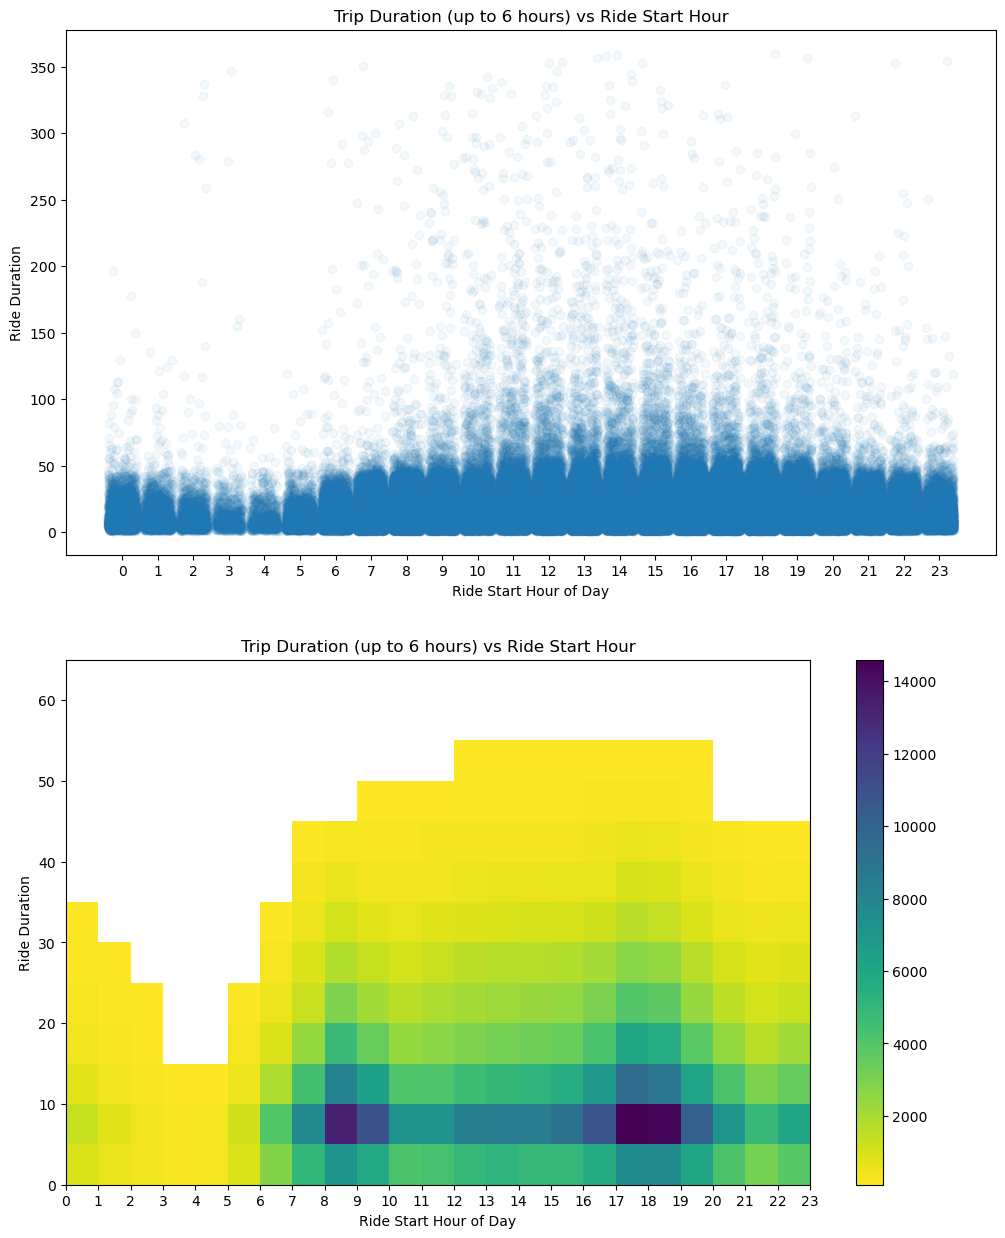

In [61]:
fig, ax = plt.subplots(nrows=2, figsize=(12,15))
trip_data_sample = trip_data.sample(500000)
#Select only observations with tripdurations less than 6 hours inorder to have a clearer insight and avoid unreasonably long uses.
trip_data_sample = trip_data_sample[trip_data_sample.tripduration < 60*60*6]
sns.regplot(x=trip_data_sample.starttime.dt.hour, y=trip_data_sample.tripduration/60, ax = ax[0], x_jitter=0.4, scatter_kws={'alpha':0.05}, fit_reg=False)
ax[0].set_xticks(np.arange(0, 24, 1));
ax[0].set_xlabel('Ride Start Hour of Day');
ax[0].set_ylabel('Ride Duration');
ax[0].set_title('Trip Duration (up to 6 hours) vs Ride Start Hour');

bins_x = np.arange(0, 24, 1)
bins_y = np.arange(0, 60+10, 5)
plt.hist2d(x=trip_data_sample.starttime.dt.hour, y=trip_data_sample.tripduration/60, cmap= 'viridis_r', cmin=100, bins=[bins_x, bins_y]);
plt.colorbar();
ax[1].set_xticks(bins_x);
ax[1].set_xlabel('Ride Start Hour of Day');
ax[1].set_ylabel('Ride Duration');
ax[1].set_title('Trip Duration (up to 6 hours) vs Ride Start Hour');
del(trip_data_sample)

As can be seen on both the scatterplot and the heatmap, longer trips are more common during the middle of the day.

### Does the trip duration vary by Month?

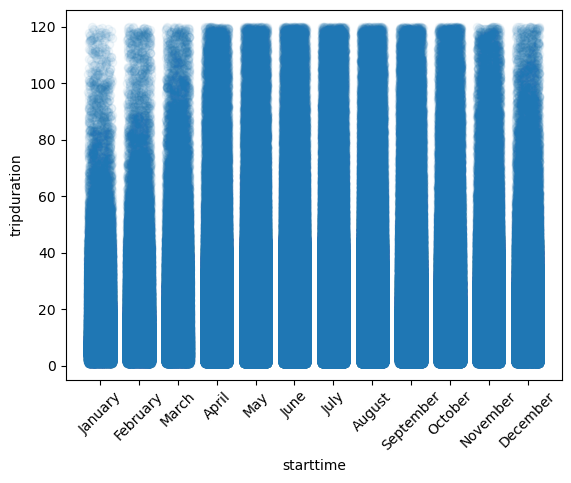

In [62]:
trip_data_sample = trip_data[trip_data.tripduration < 60*60*2]
sns.regplot(x=trip_data_sample.starttime.dt.month, y=trip_data_sample.tripduration/60, x_jitter=0.3, scatter_kws={'alpha':0.05}, fit_reg=False)
months= ['January','February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
plt.xticks(ticks=[1,2,3,4,5,6,7,8,9,10,11,12], labels=months, rotation=45);

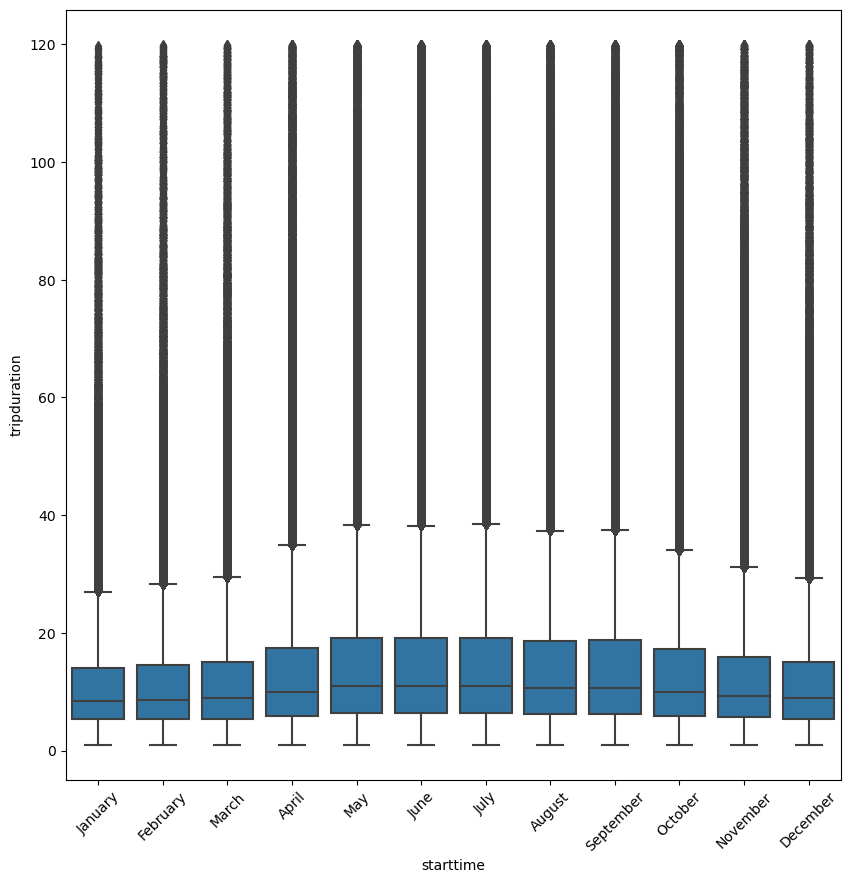

In [63]:
fig, ax = plt.subplots(figsize=(10,10))
sns.boxplot(x=trip_data_sample.starttime.dt.month, y=trip_data_sample.tripduration/60, color=sns.color_palette()[0])
months= ['January','February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
plt.xticks(ticks=[0,1,2,3,4,5,6,7,8,9,10,11], labels=months, rotation=45);

Longer trips are more common during the months that are generally warmer and have nicer weather. The box plot confirms this with the higher medians during those months and greater IQR.

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

Usage patterns by hour of the day shifted during the weekend and provided a very interesting insight, refinforcing the possibility that the weekday pattern's bimodal distribution is driven by commuters. 
User types showed different usage patterns by day of the week, hour of day, and trip durations. This shows that the user types are actually different groups and not just different subscription lengths.
Male and female pusage patterns were generally the same over the days of the week and hours of the day. Ride distribution by gender showed a similar general profile altough the female median trip duration was higher. 
Trip duration varied with hour of the day and month too.
### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

Customer user types were responsible for a far greater share of 'other' gender attribute compared to subscribers. As mentioned previously, this could be due to default input and no verifications rather than it being due to a differnt user group.

## Multivariate Exploration

### Do different user types have different ride distributions during the weekend over the hours of the day ?

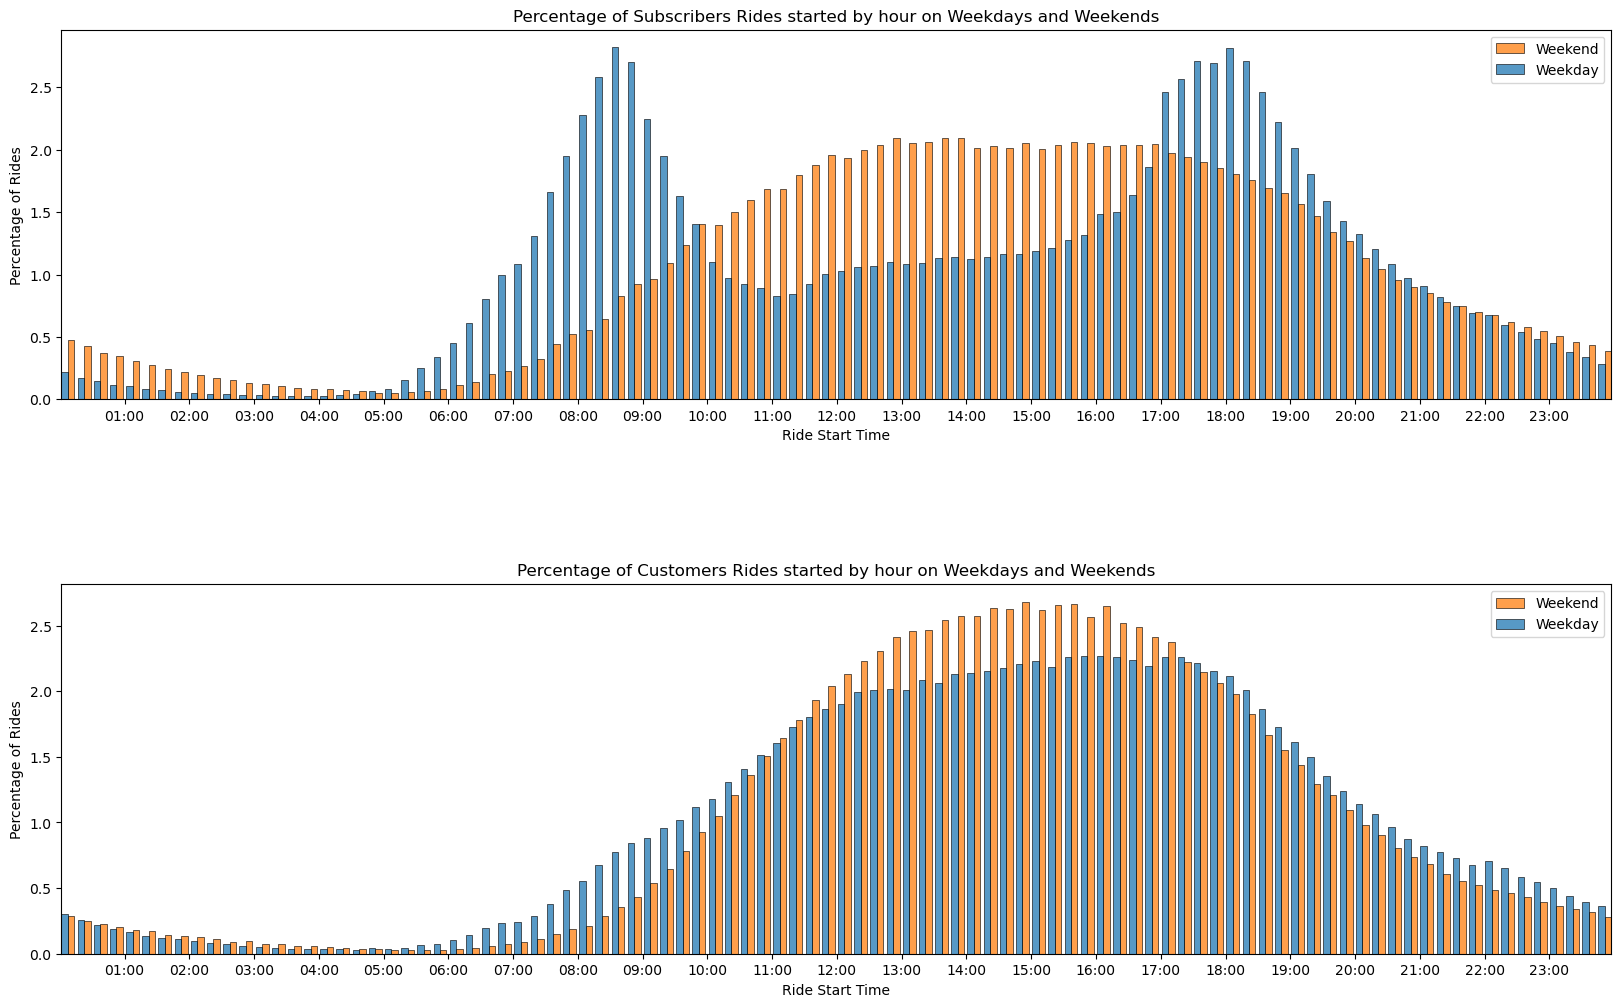

In [65]:
#Facetting by user type
fig, ax = plt.subplots(nrows=2, figsize=(20,12), gridspec_kw={'hspace':1/2})

#Subscribers
trip_data_subscribers = trip_data[trip_data.usertype == 'Subscriber']
#plot the minute of day (total minutes) by adding the hours*60 and minutes of the datetime objects.
#96 bins will be used to plot 15 minute intervals
sns.histplot(x= trip_data_subscribers.starttime.dt.hour *60 + trip_data_subscribers.starttime.dt.minute, bins = 24*4, ax=ax[0], 
             hue=trip_data_subscribers.starttime.dt.weekday.apply(day_type), 
             stat = 'percent', common_norm=False, multiple="dodge", shrink =0.8)

#Format Tick Labels
def label_chart(ax, axis_number, usertype):
    ticks = np.arange(0, 24*60,60);
    labels = [f'{x}:00' for x in range(0,24,1) ];
    labels = [f'0{x}' if len(x)<5 else x for x in labels ]
    ax[axis_number].set_xticks(ticks=ticks, labels=labels);
    ax[axis_number].margins(x=0);
    ax[axis_number].legend(['Weekend', 'Weekday'])
    ax[axis_number].set_xlabel('Ride Start Time');
    ax[axis_number].set_ylabel('Percentage of Rides');
    ax[axis_number].set_title(f'Percentage of {usertype} Rides started by hour on Weekdays and Weekends');

del(trip_data_subscribers)
label_chart(ax, 0, 'Subscribers')
#Customers
trip_data_customers = trip_data[trip_data.usertype == 'Customer']
#plot the minute of day (total minutes) by adding the hours*60 and minutes of the datetime objects.
#96 bins will be used to plot 15 minute intervals
sns.histplot(x= trip_data_customers.starttime.dt.hour *60 + trip_data_customers.starttime.dt.minute, bins = 24*4, ax=ax[1], 
             hue=trip_data_customers.starttime.dt.weekday.apply(day_type), 
             stat = 'percent', common_norm=False, multiple="dodge", shrink =0.8)
label_chart(ax, 1, 'Customers')
del(trip_data_customers)

As opposed to subscribers, customer usage patterns don't change. Except for that, there are no additional insights that were not covered in the univariate and bivariate sections of this exploratory analysis.

### Rides per year for each gender by age group.

In [66]:
# Get ride counts by age group for males
male_ride_counts = trip_data[(trip_data.birth_year >=1930) & (trip_data.gender == 1)].birth_year.value_counts(sort=False)
male_ride_counts = process_ride_counts(male_ride_counts)
nyc_population_over18 = get_age_group_ride_count(nyc_population_over18,male_ride_counts, 'male')

# Get ride counts by age group for females
female_ride_counts = trip_data[(trip_data.birth_year >=1930) & (trip_data.gender == 2)].birth_year.value_counts(sort=False)
female_ride_counts = process_ride_counts(female_ride_counts)
nyc_population_over18 = get_age_group_ride_count(nyc_population_over18,female_ride_counts, 'female')

#Get rides per person per year
nyc_population_over18['combined_rides_per_year'] = nyc_population_over18['combined_rides_count']/nyc_population_over18['combined']
nyc_population_over18['male_rides_per_year'] = nyc_population_over18['male_rides_count']/nyc_population_over18['male']
nyc_population_over18['female_rides_per_year'] = nyc_population_over18['female_rides_count']/nyc_population_over18['female']


In [67]:
nyc_population_over18.head()

,age_group,combined,male,female,combined_rides_count,male_rides_count,female_rides_count,combined_rides_per_year,male_rides_per_year,female_rides_per_year
0,18-19,176598,87736,88862,131838,100510.0,30689.0,0.746543,1.145596,0.345356
1,20-24,534372,257674,276698,1163721,812659.0,343150.0,2.177736,3.153826,1.240161
2,25-29,776107,377117,398990,3231612,2285929.0,926101.0,4.163874,6.061591,2.321113
3,30-34,723193,356269,366924,3127628,2280840.0,824628.0,4.324749,6.402016,2.247408
4,35-39,613975,299914,314061,2266250,1726949.0,520650.0,3.691111,5.758147,1.657799


In [68]:
ride_rates = pd.melt(nyc_population_over18, id_vars=['age_group'], var_name= 'gender', value_name='rides_per_year', value_vars=['male_rides_per_year', 'female_rides_per_year'] )
#rename values after melt to make sense
ride_rates.replace('male_rides_per_year', 'male', inplace=True)
ride_rates.replace('female_rides_per_year', 'female', inplace=True)
ride_rates.head()

,age_group,gender,rides_per_year
0,18-19,male,1.145596
1,20-24,male,3.153826
2,25-29,male,6.061591
3,30-34,male,6.402016
4,35-39,male,5.758147


In [69]:
#Calculate the average multiple of rides per year between male and female riders for every age group.
#This will help us see which age groups contribute more/less to the female and male rides per year rates
coefficient = ride_rates[ride_rates.gender == 'male'].rides_per_year.mean()/ride_rates[ride_rates.gender == 'female'].rides_per_year.mean()

In [70]:
coefficient

3.2041317055159566

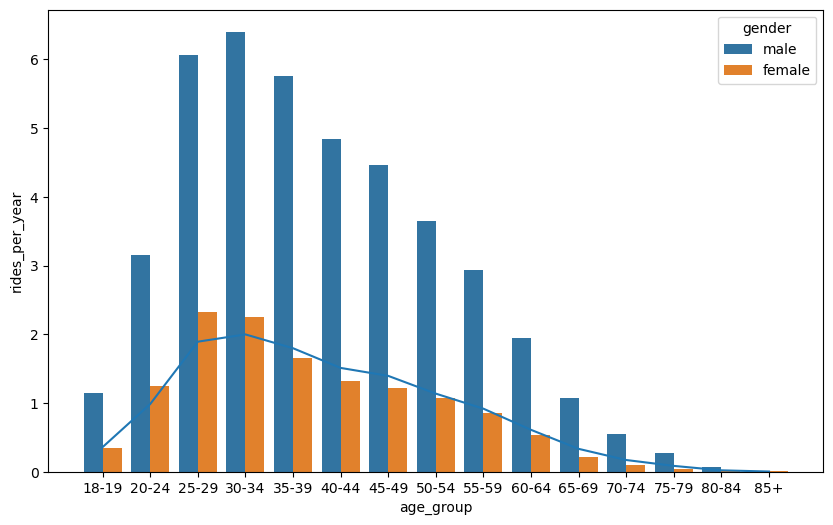

In [71]:
fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(x=ride_rates.age_group, y=ride_rates.rides_per_year, hue=ride_rates.gender)
plt.plot(ride_rates[ride_rates.gender == 'male'].rides_per_year/coefficient);

Females between 20 to 34 have a slightly higher than average contribution to the difference between male and female riders. However, they still use bikes far less than their male counterparts.

### Is there a relationship between gender, age and trip duration?

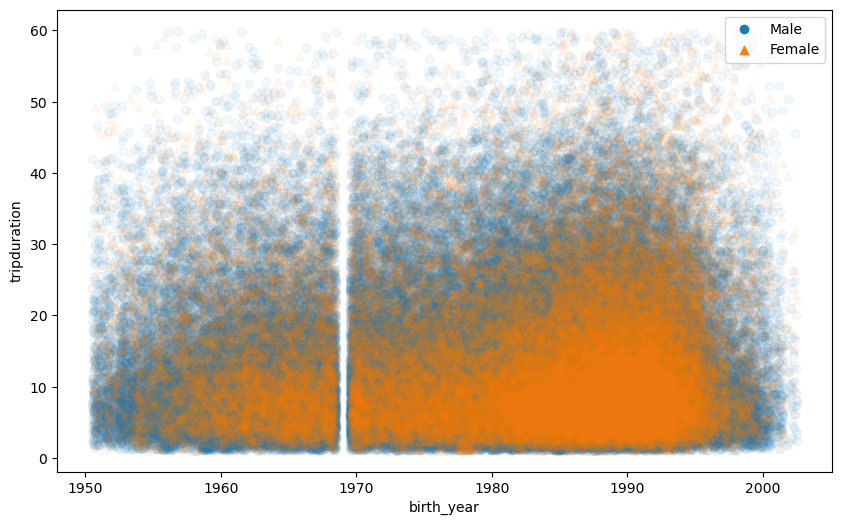

In [96]:
gender_markers = [[1, 'o', 'Male'],
                 [2, '^', 'Female'],
                 ]
trip_data_sample= trip_data[(trip_data.birth_year != 1969) & (trip_data.tripduration <= 1*60*60) & 
                            (trip_data.birth_year >1950)].sample(200000)
plt.figure(figsize=(10,6))
for gender, marker, label in gender_markers:
    trip_data_sample2 = trip_data_sample[trip_data_sample.gender == gender]
    sns.regplot(x=trip_data_sample2.birth_year, y=trip_data_sample2.tripduration/60,  fit_reg=False, 
                                    marker= marker, x_jitter=0.5, scatter_kws={'alpha': 1/20}, label= label)
    del(trip_data_sample2)
leg = plt.legend(loc='upper right')
for lh in leg.legendHandles: 
    lh.set_alpha(1)
del(trip_data_sample)

There is no insight between the three variables. There are only bivariate relationships that were already covered.

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

Customers used bikes in a similary way throughout the day during the whole week while the behaviour of subscribers changed. This shows that they are different groups of people. Subscribers are likely to be the locals while customers are tourists or occasional users.
Young females between 20 to 34 have a slightly higher than average contribution to the difference between male and female riders despite still being far off their male counterparts.

### Were there any interesting or surprising interactions between features?

No.

## Conclusions
The data required some cleaning and using the NYC population data helped get a more accurate analysis in age and gender related usage patters.

* Usage depended heavily on the time of day and the distribution was bimodal; with the peaks aligning with a typical commuter's day (9-5). Looking at the distribution of rides over the weekend supports the hypothesis that the bimodal distribution is driven by commuters as the bimodal peak dissapeared and we instead had a normal distribution. This normal distribution applied to the customer usertypes throughout the whole week with no changes during the week or weekend.

* An analysis of the usage of bikes by the day of the week showed less use over the weekend. Looking at the customer group in isolation showed that they used the bikes a lot more (45% of total rides) during the weekend. 
* Analysis of the ride count by month showed that bike usage does fluctuate throughout the year. Temperature and weather sensitivity of riders is suggested as usage is a lot less during colder and rainy months and peaks during the summer months.

* Trip duration analysis showed that the bikes were mainly used for short trips but usage over longer trips were still common. Customers had a more varied and evenly distributed trip duration between 10 and 30 minutes. Subscribers had a high concentration below 10 minutes. Trip duration varied by month with the warmer month having more long trips. It also varied by the time of day with most long rides being recorded between 9 A.M and 6 P.M.

* Males used the bikes 3 times more than females when the number of rides were adjusted by population. Younger female groups were slightly driving down that multiple but still were far off from their male counterparts.

* 89% of rides were by subscribers while customers were responsible for only 11% of the rides.

* The analysis of rides by age group when adjusted for by population showed a peak in the 25 to 34 year group and a slow decline in every subsequent group. An unexpected insight was how few the rides by the 18 to 24 year old group age were.


In [97]:
trip_data.to_csv('trip_data_clean')
nyc_population_over18.to_csv('nyc_population_over18_clean')

In [98]:
del(trip_data)